# Required Packages

Before running this notebook, ensure you have the following packages installed:

```bash
pip install yfinance pandas numpy xlrd matplotlib seaborn requests
```

**Package List:**
- `yfinance` - Download financial market data from Yahoo Finance
- `pandas` - Data manipulation and analysis
- `numpy` - Numerical computing
- `xlrd` - Reading Excel files (.xls format)
- `matplotlib` - Data visualization
- `seaborn` - Statistical data visualization
- `requests` - HTTP library for downloading files


---


## Overview
This notebook implements a data pipeline for predicting crude oil market movements using machine learning. We collect and engineer features from multiple market indicators including:
- **Energy commodities**: Crude oil (WTI & Brent), gasoline, heating oil, natural gas
- **Macro indicators**: US Dollar Index (DXY), US 10-Year Treasury, Oil Volatility Index
- **Cross-market signals**: Gold, copper, S&P 500, emerging markets
- **Sector-specific**: Energy stocks, transportation, oil services, credit risk

## Data Range & Considerations
- **Start Date**: 2021-01-01 (Post-COVID recovery period)
- **Frequency**: Daily
- **Rationale**: Avoids COVID-19 market disruption while capturing recent market dynamics

## Key Questions
- How far back should training data extend? Post-2020 data avoids pandemic anomalies but reduces sample size.
- Does adding more variables improve signal or introduce noise? Need to evaluate feature importance.

## Step 1: Import Libraries

In [130]:
import yfinance as yf
import pandas as pd


data = yf.download("CL=F", start="2021-01-01", interval="1d")

print("Columns:", data.columns)
print("-" * 30)
print(data.head())

ticker_info = yf.Ticker("CL=F").info
print("-" * 30)
print("Currency", ticker_info.get('currency'))
print("Exchange:", ticker_info.get('exchange'))
print("Timezone:", ticker_info.get('exchangeTimezoneName'))

/var/folders/_x/1pnr6wwx33nd4yqyttygrv580000gn/T/ipykernel_74566/415992674.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("CL=F", start="2021-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


Columns: MultiIndex([( 'Close', 'CL=F'),
            (  'High', 'CL=F'),
            (   'Low', 'CL=F'),
            (  'Open', 'CL=F'),
            ('Volume', 'CL=F')],
           names=['Price', 'Ticker'])
------------------------------
Price           Close       High        Low       Open  Volume
Ticker           CL=F       CL=F       CL=F       CL=F    CL=F
Date                                                          
2021-01-04  47.619999  49.830002  47.180000  48.400002  528525
2021-01-05  49.930000  50.200001  47.240002  47.380001  643191
2021-01-06  50.630001  50.939999  49.480000  49.820000  509365
2021-01-07  50.830002  51.279999  50.389999  50.529999  369292
2021-01-08  52.240002  52.750000  50.810001  50.930000  499416
------------------------------
Currency USD
Exchange: NYM
Timezone: America/New_York


## Step 2: Data Collection - Multi-Asset Download

We fetch daily prices for multiple assets that influence or correlate with crude oil prices. These include:
1. **Energy Futures**: WTI crude, Brent crude, gasoline, heating oil, natural gas
2. **Currency**: US Dollar Index (impacts commodity prices denominated in USD)
3. **Rates & Volatility**: 10-year Treasury yield, Oil VIX
4. **Commodities**: Gold, copper (industrial demand proxy)
5. **Equities**: S&P 500, energy sector ETF, emerging markets
6. **Economic Activity Proxies**: Transportation index (demand), oil services (supply response)
7. **Credit Risk**: High-yield corporate bonds (shale oil financing conditions)

In [131]:
# Define ticker symbols and their readable column names
tickers = {
    "CL=F": "Crude_Oil",           # WTI Crude Oil (NYMEX)
    "RB=F": "Gasoline",            # RBOB Gasoline futures
    "HO=F": "Heating_Oil",         # Heating Oil futures
    "BZ=F": "Brent_Oil",           # Brent Crude (international benchmark)
    "NG=F": "Natural_Gas",         # Natural Gas futures
    "DX-Y.NYB": "DXY",             # US Dollar Index
    "^TNX": "US10Y",               # 10-Year Treasury Yield
    "^OVX": "Oil_VIX",             # Oil Volatility Index
    "CAD=X": "USD_CAD",            # USD/CAD exchange rate
    "HG=F": "Copper",              # Copper futures
    "GC=F": "Gold",                # Gold futures
    "^GSPC": "SP500",              # S&P 500 Index
    "XLE": "Energy_Stocks",        # Energy Select Sector SPDR
    "EEM": "Emerging_Mkt",         # Emerging Markets ETF
    "TIP": "Inflation_Tips",       # Treasury Inflation-Protected Securities
    "IYT": "Transportation",       # Transportation sector (demand proxy)
    "OIH": "Oil_Services",         # Oil services sector (supply response proxy)
    "HYG": "Junk_Bond",            # High-yield corporate bonds (credit risk for shale producers)
}

# Download all tickers at once (yfinance returns multi-level columns)
df_raw = yf.download(list(tickers.keys()), start="2021-01-01", interval="1d", group_by='column')

# Extract closing prices (prefer Adj Close if available)
try:
    if 'Adj Close' in df_raw.columns.get_level_values(0):
        df_all = df_raw['Adj Close'].copy()
    else:
        df_all = df_raw['Close'].copy()
except KeyError:
    df_all = df_raw['Close'].copy()

# Rename columns to readable names
df_all.rename(columns=tickers, inplace=True)

# Clean data: remove completely empty columns and rows with any NaN
df_all.dropna(how='all', axis=1, inplace=True)
df_all.dropna(inplace=True)



/var/folders/_x/1pnr6wwx33nd4yqyttygrv580000gn/T/ipykernel_74566/807572668.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(list(tickers.keys()), start="2021-01-01", interval="1d", group_by='column')
[*********************100%***********************]  18 of 18 completed


## Step 3: Data Completeness Validation

Before feature engineering, verify that all downloaded variables have complete data with no missing values.

In [132]:
# Check data completeness for all variables
print("=" * 70)
print("DATA COMPLETENESS CHECK")
print("=" * 70)

# Calculate missing values before and after cleaning
total_rows = len(df_all)
missing_counts = df_all.isna().sum()
missing_pct = (missing_counts / total_rows * 100).round(2)

# Create summary dataframe
completeness_df = pd.DataFrame({
    'Variable': df_all.columns,
    'Missing_Count': missing_counts.values,
    'Missing_Pct': missing_pct.values,
    'Complete_Count': (total_rows - missing_counts).values,
    'Data_Status': ['✓ Complete' if x == 0 else '✗ Incomplete' for x in missing_counts.values]
})

print(completeness_df.to_string(index=False))

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"Total Variables: {len(df_all.columns)}")
print(f"Complete Variables: {(missing_counts == 0).sum()}")
print(f"Incomplete Variables: {(missing_counts > 0).sum()}")
print(f"Total Rows: {total_rows}")

if missing_counts.sum() == 0:
    print("\n✓✓✓ ALL VARIABLES ARE COMPLETE - NO MISSING DATA ✓✓✓")
else:
    print(f"\n✗ WARNING: {missing_counts.sum()} total missing values detected")
    print("Variables with missing data:")
    print(completeness_df[completeness_df['Missing_Count'] > 0][['Variable', 'Missing_Count', 'Missing_Pct']])

DATA COMPLETENESS CHECK
      Variable  Missing_Count  Missing_Pct  Complete_Count Data_Status
     Brent_Oil              0          0.0            1229  ✓ Complete
       USD_CAD              0          0.0            1229  ✓ Complete
     Crude_Oil              0          0.0            1229  ✓ Complete
           DXY              0          0.0            1229  ✓ Complete
  Emerging_Mkt              0          0.0            1229  ✓ Complete
          Gold              0          0.0            1229  ✓ Complete
        Copper              0          0.0            1229  ✓ Complete
   Heating_Oil              0          0.0            1229  ✓ Complete
     Junk_Bond              0          0.0            1229  ✓ Complete
Transportation              0          0.0            1229  ✓ Complete
   Natural_Gas              0          0.0            1229  ✓ Complete
  Oil_Services              0          0.0            1229  ✓ Complete
      Gasoline              0          0.0           

## Step 4: Feature Engineering - Financial Ratios

We calculate several key financial ratios that capture inter-market relationships and economic fundamentals:

### 1. **Crack Spread (3:2:1 Ratio)**
The "crack spread" measures refining margins — how much profit refiners earn by cracking crude oil into gasoline and heating oil.

$$
\text{Crack Spread (3:2:1)} = \frac{2 \times \text{Gasoline Price} + 1 \times \text{Heating Oil Price}}{3} - \text{Crude Oil Price}
$$

- **Units**: USD per barrel
- **Interpretation**: 
  - Positive spread → Refiners profitable → Strong downstream demand
  - Negative spread → Weak refining margins → Potential demand slowdown

**Why it matters**: A widening crack spread signals strong oil product demand, which can support crude prices. A narrowing spread may indicate oversupply or weak demand.

---

### 2. **Gold-to-Oil Ratio**
Measures how many barrels of oil can be purchased with one ounce of gold.

$$
\text{Gold/Oil Ratio} = \frac{\text{Gold Price (USD/oz)}}{\text{Crude Oil Price (USD/bbl)}}
$$

- **Typical Range**: 15-20 barrels per ounce
- **Interpretation**:
  - High ratio (>25) → Oil undervalued or gold overvalued (flight to safety, weak oil demand)
  - Low ratio (<10) → Oil expensive relative to gold (strong energy demand or inflation)

**Why it matters**: This ratio is a cross-asset value indicator. Extreme readings may signal mean reversion opportunities.

---

### 3. **Copper-to-Oil Ratio**
Compares the price of copper (industrial metal) to crude oil (energy).

$$
\text{Copper/Oil Ratio} = \frac{\text{Copper Price (USD/lb)}}{\text{Crude Oil Price (USD/bbl)}}
$$

- **Interpretation**:
  - Rising ratio → Copper outperforming → Manufacturing/construction boom → Future energy demand may follow
  - Falling ratio → Weak industrial activity → Potential oil demand slowdown

**Why it matters**: Copper is a leading indicator of industrial activity. A rising copper/oil ratio can forecast increasing energy demand as factories ramp up.

---

### 4. **Transportation-to-Oil Ratio (IYT/Oil)**
Compares transportation sector performance to oil prices.

$$
\text{Transport/Oil Ratio} = \frac{\text{IYT Index}}{\text{Crude Oil Price}}
$$

- **Interpretation**:
  - Rising ratio → Transportation sector outperforming despite oil prices → Strong logistics demand
  - Falling ratio → High oil prices hurting transport margins → Demand destruction risk

**Why it matters**: Transportation companies are major oil consumers. This ratio gauges how well they're absorbing energy costs.

---

### 5. **Oil Services-to-Oil Ratio (OIH/Oil)**
Compares oilfield services sector to crude oil prices.

$$
\text{Services/Oil Ratio} = \frac{\text{OIH Index}}{\text{Crude Oil Price}}
$$

- **Interpretation**:
  - Rising ratio → Services sector gaining relative to oil prices → Expectations of supply growth
  - Falling ratio → Services lagging → Limited supply response or high breakeven costs

**Why it matters**: When this ratio rises, it suggests the market expects higher drilling activity (supply response), which could cap future price gains.

In [133]:
# Apply feature engineering transformations

# 1. Crack Spread (3:2:1 ratio)
if 'Gasoline' in df_all.columns and 'Heating_Oil' in df_all.columns and 'Crude_Oil' in df_all.columns:
    gas_per_bbl = df_all['Gasoline'] * 42
    heat_per_bbl = df_all['Heating_Oil'] * 42
    df_all['Crack_Spread_321'] = (2 * gas_per_bbl + 1 * heat_per_bbl - 3 * df_all['Crude_Oil']) / 3
    print("✓ Crack Spread (3:2:1)")
else:
    print("✗ Missing columns for Crack Spread")

# 2. Gold/Oil Ratio
if 'Gold' in df_all.columns and 'Crude_Oil' in df_all.columns:
    df_all['Gold_Oil_Ratio'] = df_all['Gold'] / df_all['Crude_Oil']
    print("✓ Gold/Oil Ratio")

# 3. Copper/Oil Ratio
if 'Copper' in df_all.columns and 'Crude_Oil' in df_all.columns:
    df_all['Copper_Oil_Ratio'] = df_all['Copper'] / df_all['Crude_Oil']
    print("✓ Copper/Oil Ratio")

# 4. Transportation/Oil Ratio
if 'Transportation' in df_all.columns and 'Crude_Oil' in df_all.columns:
    df_all['Transport_Oil_Ratio'] = df_all['Transportation'] / df_all['Crude_Oil']
    print("✓ Transportation/Oil Ratio")

# 5. Oil Services/Oil Ratio
if 'Oil_Services' in df_all.columns and 'Crude_Oil' in df_all.columns:
    df_all['Service_Oil_Ratio'] = df_all['Oil_Services'] / df_all['Crude_Oil']
    print("✓ Oil Services/Oil Ratio")

print("\n" + "=" * 50)
print(f"✓ Feature engineering complete")
print(f"✓ Total features after engineering: {len(df_all.columns)}")
print("=" * 50)

✓ Crack Spread (3:2:1)
✓ Gold/Oil Ratio
✓ Copper/Oil Ratio
✓ Transportation/Oil Ratio
✓ Oil Services/Oil Ratio

✓ Feature engineering complete
✓ Total features after engineering: 23


## Step 5: Feature Engineering - Technical Indicators

Calculate technical indicators for crude oil price (CL=F) to capture market momentum, volatility, and trend patterns. These indicators are commonly used in quantitative trading strategies.

In [134]:
# ==========================================
# 1. TECHNICAL INDICATORS (技术指标)
# ==========================================

print("=" * 80)
print("CALCULATING TECHNICAL INDICATORS FOR CRUDE OIL (CL=F)")
print("=" * 80)

# Use crude oil closing price as base for technical indicators
price = df_all['Crude_Oil']

print(f"\nBase price series: Crude_Oil (Crude Oil Futures)")
print(f"Date range: {df_all.index.min().date()} to {df_all.index.max().date()}")
print(f"Total observations: {len(price)}")

# A. Moving Averages (均线) - Trend identification
print("\n1. Calculating Moving Averages...")
df_all['SMA_5'] = price.rolling(window=5).mean()
df_all['SMA_20'] = price.rolling(window=20).mean()
df_all['SMA_50'] = price.rolling(window=50).mean()

# Price deviation from moving average (乖离率)
df_all['Dist_SMA_20'] = (price - df_all['SMA_20']) / df_all['SMA_20']
df_all['Dist_SMA_50'] = (price - df_all['SMA_50']) / df_all['SMA_50']

print("   ✓ SMA_5, SMA_20, SMA_50")
print("   ✓ Dist_SMA_20, Dist_SMA_50 (price deviation from MA)")

# B. Bollinger Bands (布林带) - Volatility bands
print("\n2. Calculating Bollinger Bands...")
rolling_std = price.rolling(window=20).std()
df_all['BB_Upper'] = df_all['SMA_20'] + (rolling_std * 2)
df_all['BB_Lower'] = df_all['SMA_20'] - (rolling_std * 2)
df_all['BB_Width'] = (df_all['BB_Upper'] - df_all['BB_Lower']) / df_all['SMA_20']

# %B indicator (position within Bollinger Bands)
df_all['BB_Position'] = (price - df_all['BB_Lower']) / (df_all['BB_Upper'] - df_all['BB_Lower'])

print("   ✓ BB_Upper, BB_Lower, BB_Width")
print("   ✓ BB_Position (0 = lower band, 1 = upper band)")

# C. RSI (Relative Strength Index) - Overbought/oversold
print("\n3. Calculating RSI...")

def calculate_rsi(series, period=14):
    """Calculate Relative Strength Index"""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_all['RSI_14'] = calculate_rsi(price, period=14)
df_all['RSI_28'] = calculate_rsi(price, period=28)

print("   ✓ RSI_14, RSI_28 (0-100 scale)")
print("   ✓ RSI > 70: overbought, RSI < 30: oversold")

# D. MACD (Moving Average Convergence Divergence) - Trend momentum
print("\n4. Calculating MACD...")
ema12 = price.ewm(span=12, adjust=False).mean()
ema26 = price.ewm(span=26, adjust=False).mean()
df_all['MACD'] = ema12 - ema26
df_all['MACD_Signal'] = df_all['MACD'].ewm(span=9, adjust=False).mean()
df_all['MACD_Hist'] = df_all['MACD'] - df_all['MACD_Signal']

print("   ✓ MACD, MACD_Signal, MACD_Hist")
print("   ✓ MACD crossover signals trend reversals")

CALCULATING TECHNICAL INDICATORS FOR CRUDE OIL (CL=F)

Base price series: Crude_Oil (Crude Oil Futures)
Date range: 2021-01-04 to 2025-11-24
Total observations: 1229

1. Calculating Moving Averages...
   ✓ SMA_5, SMA_20, SMA_50
   ✓ Dist_SMA_20, Dist_SMA_50 (price deviation from MA)

2. Calculating Bollinger Bands...
   ✓ BB_Upper, BB_Lower, BB_Width
   ✓ BB_Position (0 = lower band, 1 = upper band)

3. Calculating RSI...
   ✓ RSI_14, RSI_28 (0-100 scale)
   ✓ RSI > 70: overbought, RSI < 30: oversold

4. Calculating MACD...
   ✓ MACD, MACD_Signal, MACD_Hist
   ✓ MACD crossover signals trend reversals


In [135]:
# ==========================================
# 2. MOMENTUM & VOLATILITY (动量与波动率)
# ==========================================

print("\n" + "=" * 80)
print("CALCULATING MOMENTUM & VOLATILITY FEATURES")
print("=" * 80)

# A. Returns (收益率)
print("\n1. Calculating Returns...")
df_all['Ret_1d'] = price.pct_change(1)
df_all['Ret_5d'] = price.pct_change(5)
df_all['Ret_20d'] = price.pct_change(20)
df_all['Ret_60d'] = price.pct_change(60)

print("   ✓ Ret_1d, Ret_5d, Ret_20d, Ret_60d")
print("   ✓ Daily, weekly, monthly, quarterly returns")

# B. Realized Volatility (历史波动率)
print("\n2. Calculating Realized Volatility...")
df_all['Realized_Vol_20d'] = df_all['Ret_1d'].rolling(window=20).std()
df_all['Realized_Vol_60d'] = df_all['Ret_1d'].rolling(window=60).std()

# Annualize volatility (assuming 252 trading days)
df_all['Annual_Vol_20d'] = df_all['Realized_Vol_20d'] * np.sqrt(252)

print("   ✓ Realized_Vol_20d, Realized_Vol_60d")
print("   ✓ Annual_Vol_20d (annualized)")

# C. Volatility Adjusted Momentum (波动率调整动量)
print("\n3. Calculating Volatility Adjusted Momentum...")
# Prevent division by zero
df_all['Vol_Adj_Mom_20d'] = df_all['Ret_20d'] / (df_all['Realized_Vol_20d'] + 1e-6)
df_all['Vol_Adj_Mom_60d'] = df_all['Ret_60d'] / (df_all['Realized_Vol_60d'] + 1e-6)

print("   ✓ Vol_Adj_Mom_20d, Vol_Adj_Mom_60d")
print("   ✓ Return / Volatility ratio (risk-adjusted momentum)")

# D. Price Range & True Range (价格波动幅度)
print("\n4. Calculating Price Range...")
# Since we only have Close prices, use rolling high/low
rolling_high = price.rolling(window=20).max()
rolling_low = price.rolling(window=20).min()
df_all['Price_Range_20d'] = (rolling_high - rolling_low) / price

print("   ✓ Price_Range_20d (20-day high-low range)")

# E. Rate of Change (变化率)
print("\n5. Calculating Rate of Change...")
df_all['ROC_5'] = (price - price.shift(5)) / price.shift(5)
df_all['ROC_20'] = (price - price.shift(20)) / price.shift(20)

print("   ✓ ROC_5, ROC_20 (momentum indicators)")


CALCULATING MOMENTUM & VOLATILITY FEATURES

1. Calculating Returns...
   ✓ Ret_1d, Ret_5d, Ret_20d, Ret_60d
   ✓ Daily, weekly, monthly, quarterly returns

2. Calculating Realized Volatility...
   ✓ Realized_Vol_20d, Realized_Vol_60d
   ✓ Annual_Vol_20d (annualized)

3. Calculating Volatility Adjusted Momentum...
   ✓ Vol_Adj_Mom_20d, Vol_Adj_Mom_60d
   ✓ Return / Volatility ratio (risk-adjusted momentum)

4. Calculating Price Range...
   ✓ Price_Range_20d (20-day high-low range)

5. Calculating Rate of Change...
   ✓ ROC_5, ROC_20 (momentum indicators)


In [136]:
# ==========================================
# 3. LAGGED FEATURES (滞后特征)
# ==========================================

print("\n" + "=" * 80)
print("CREATING LAGGED FEATURES")
print("=" * 80)

# Crude oil price lags
print("\n1. Crude Oil Price Lags...")
df_all['Oil_Lag1'] = price.shift(1)
df_all['Oil_Lag2'] = price.shift(2)
df_all['Oil_Lag3'] = price.shift(3)
df_all['Oil_Lag5'] = price.shift(5)

print("   ✓ Oil_Lag1, Oil_Lag2, Oil_Lag3, Oil_Lag5")

# Key indicator lags (RSI, MACD)
print("\n2. Indicator Lags...")
df_all['RSI_14_Lag1'] = df_all['RSI_14'].shift(1)
df_all['MACD_Hist_Lag1'] = df_all['MACD_Hist'].shift(1)

print("   ✓ RSI_14_Lag1, MACD_Hist_Lag1")

# Return lags
print("\n3. Return Lags...")
df_all['Ret_1d_Lag1'] = df_all['Ret_1d'].shift(1)
df_all['Ret_1d_Lag2'] = df_all['Ret_1d'].shift(2)

print("   ✓ Ret_1d_Lag1, Ret_1d_Lag2")


CREATING LAGGED FEATURES

1. Crude Oil Price Lags...
   ✓ Oil_Lag1, Oil_Lag2, Oil_Lag3, Oil_Lag5

2. Indicator Lags...
   ✓ RSI_14_Lag1, MACD_Hist_Lag1

3. Return Lags...
   ✓ Ret_1d_Lag1, Ret_1d_Lag2


## Step 6: Weekly Fundamental Data Integration (EIA Reports)

Integrate 7 Excel files containing weekly crude oil fundamental data from the U.S. Energy Information Administration (EIA):

**Files to integrate:**
- `psw01.xls` - 3 sheets: Weekly fundamental data (Data 1, 2, 3)
- `psw02.xls` - 2 sheets: Supply/demand balance data  
- `psw03.xls` - 2 sheets: Inventory and production data
- `psw04.xls` - 1 sheet: Regional supply data
- `psw05.xls` - 2 sheets: Refinery operations data
- `psw06.xls` - 3 sheets: Imports/exports data
- `psw07.xls` - 2 sheets: Product stocks data

**Total: 15 sheets of weekly EIA data**

**Integration Strategy:**
1. Read each Excel sheet and detect date column
2. Convert to datetime and set as index
3. Filter data from 2021-01-01 onwards
4. Add source prefix to column names (e.g., `Weekly_`, `PSW02_`)
5. Resample weekly data to daily frequency using forward-fill: `resample('D').ffill()`
6. Join with main dataset (`df_all`)

**Note**: Forward-filling ensures each weekly value applies to all trading days until the next weekly update.

In [ ]:
import xlrd
import numpy as np  # Needed for data validation later


In [ ]:
# Read all three sheets from the Excel file
excel_file_path = '/Users/arthurf/Downloads/psw01.xls'

print("=" * 70)
print("READING WEEKLY FUNDAMENTAL DATA")
print("=" * 70)

# Read all three sheets
sheet_names = ['Data 1', 'Data 2', 'Data 3']
weekly_data_dict = {}

for sheet_name in sheet_names:
    try:
        df_sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)
        weekly_data_dict[sheet_name] = df_sheet
        print(f"\n✓ Successfully loaded: {sheet_name}")
        print(f"  Shape: {df_sheet.shape[0]} rows × {df_sheet.shape[1]} columns")
        print(f"  Columns: {list(df_sheet.columns[:5])}..." if len(df_sheet.columns) > 5 else f"  Columns: {list(df_sheet.columns)}")
    except Exception as e:
        print(f"\n✗ Error loading {sheet_name}: {str(e)}")

print("\n" + "=" * 70)
print(f"Total sheets loaded: {len(weekly_data_dict)}")
print("=" * 70)

READING WEEKLY FUNDAMENTAL DATA

✓ Successfully loaded: Data 1
  Shape: 2252 rows × 20 columns
  Columns: ['Date', 'Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)', 'Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)', 'Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousand Barrels)', 'Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)']...

✓ Successfully loaded: Data 2
  Shape: 2252 rows × 38 columns
  Columns: ['Date', 'Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)', 'Weekly Alaska Field Production of Crude Oil  (Thousand Barrels per Day)', 'Weekly Lower 48 States Field Production of Crude Oil  (Thousand Barrels per Day)', 'Weekly U.S. Net Imports of Crude Oil  (Thousand Barrels per Day)']...

✓ Successfully loaded: Data 3
  Shape: 2250 rows × 38 columns
  Columns: ['Date', '4-Week Avg U.S. Field Production of Crude Oil  (Thousand Barrels per Day)', '4-Week Avg Alaska Field Production of Crude Oil  (Thousand Ba

In [139]:
# Inspect and preview each sheet's data structure
print("=" * 70)
print("DETAILED INSPECTION OF EACH SHEET")
print("=" * 70)

for sheet_name, df_sheet in weekly_data_dict.items():
    print(f"\n{'='*70}")
    print(f"SHEET: {sheet_name}")
    print(f"{'='*70}")
    
    # Display basic info
    print(f"\nShape: {df_sheet.shape}")
    print(f"\nColumn names ({len(df_sheet.columns)} total):")
    for i, col in enumerate(df_sheet.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Display first few rows
    print(f"\nFirst 3 rows:")
    print(df_sheet.head(3))
    
    # Check for date columns
    date_cols = [col for col in df_sheet.columns if 'date' in col.lower() or 'time' in col.lower() or 'week' in col.lower()]
    if date_cols:
        print(f"\nPotential date columns found: {date_cols}")
        print(f"Sample dates: {df_sheet[date_cols[0]].head(3).tolist()}")
    
    # Display data types
    print(f"\nData types:")
    print(df_sheet.dtypes)
    
    # Check for missing values
    missing = df_sheet.isna().sum()
    if missing.sum() > 0:
        print(f"\nMissing values:")
        print(missing[missing > 0])
    else:
        print(f"\n✓ No missing values in this sheet")

DETAILED INSPECTION OF EACH SHEET

SHEET: Data 1

Shape: (2252, 20)

Column names (20 total):
   1. Date
   2. Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)
   3. Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)
   4. Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousand Barrels)
   5. Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)
   6. Weekly U.S. Ending Stocks of Reformulated Motor Gasoline  (Thousand Barrels)
   7. Weekly U.S. Ending Stocks of Conventional Motor Gasoline  (Thousand Barrels)
   8. Weekly U.S. Ending Stocks of Gasoline Blending Components  (Thousand Barrels)
   9. Weekly U.S. Ending Stocks of Fuel Ethanol  (Thousand Barrels)
  10. Weekly U.S. Ending Stocks of Kerosene-Type Jet Fuel  (Thousand Barrels)
  11. Weekly U.S. Ending Stocks of Distillate Fuel Oil  (Thousand Barrels)
  12. Weekly U.S. Ending Stocks of Distillate Fuel Oil, 0 to 15 ppm Sulfur  (Thousand Barrels)
  13. Weekly U.S. Ending Stocks of Distilla

In [140]:
# Process and merge weekly data from all three sheets
print("=" * 70)
print("PROCESSING AND MERGING WEEKLY DATA")
print("=" * 70)

# Dictionary to store processed weekly dataframes
processed_weekly_dfs = {}

for sheet_name, df_sheet in weekly_data_dict.items():
    print(f"\nProcessing: {sheet_name}")
    
    # Create a copy to avoid modifying original
    df_weekly = df_sheet.copy()
    
    # Try to identify date column (look for common date column names)
    date_col_candidates = [col for col in df_weekly.columns 
                          if any(keyword in col.lower() for keyword in ['date', 'time', 'week', 'period'])]
    
    if date_col_candidates:
        date_col = date_col_candidates[0]
        print(f"  Found date column: '{date_col}'")
        
        # Convert to datetime
        try:
            df_weekly[date_col] = pd.to_datetime(df_weekly[date_col], errors='coerce')
            df_weekly = df_weekly.dropna(subset=[date_col])
            df_weekly.set_index(date_col, inplace=True)
            
            # Filter to match our date range (2021-01-01 onwards)
            df_weekly = df_weekly[df_weekly.index >= '2021-01-01']
            
            # Add prefix to columns to distinguish between sheets
            sheet_prefix = sheet_name.replace(' ', '_').replace('Data', 'Weekly')
            df_weekly.columns = [f"{sheet_prefix}_{col}" for col in df_weekly.columns]
            
            processed_weekly_dfs[sheet_name] = df_weekly
            print(f"  ✓ Processed shape: {df_weekly.shape}")
            print(f"  ✓ Date range: {df_weekly.index.min()} to {df_weekly.index.max()}")
            
        except Exception as e:
            print(f"  ✗ Error processing dates: {str(e)}")
    else:
        print(f"  ⚠ No clear date column found, skipping this sheet")

# Combine all processed weekly data
if processed_weekly_dfs:
    # Concatenate all sheets horizontally (join on date index)
    df_weekly_combined = pd.concat(processed_weekly_dfs.values(), axis=1, join='outer')
    
    print(f"\n{'='*70}")
    print("COMBINED WEEKLY DATA")
    print(f"{'='*70}")
    print(f"Shape: {df_weekly_combined.shape}")
    print(f"Date range: {df_weekly_combined.index.min()} to {df_weekly_combined.index.max()}")
    print(f"Total weekly features: {len(df_weekly_combined.columns)}")
    print(f"\nSample columns:")
    for i, col in enumerate(df_weekly_combined.columns[:10], 1):
        print(f"  {i:2d}. {col}")
    if len(df_weekly_combined.columns) > 10:
        print(f"  ... and {len(df_weekly_combined.columns) - 10} more")
else:
    print("\n✗ No weekly data was successfully processed")

PROCESSING AND MERGING WEEKLY DATA

Processing: Data 1
  Found date column: 'Date'
  ✓ Processed shape: (256, 19)
  ✓ Date range: 2021-01-01 00:00:00 to 2025-11-21 00:00:00

Processing: Data 2
  Found date column: 'Date'
  ✓ Processed shape: (256, 37)
  ✓ Date range: 2021-01-01 00:00:00 to 2025-11-21 00:00:00

Processing: Data 3
  Found date column: 'Date'
  ✓ Processed shape: (256, 37)
  ✓ Date range: 2021-01-01 00:00:00 to 2025-11-21 00:00:00

COMBINED WEEKLY DATA
Shape: (256, 93)
Date range: 2021-01-01 00:00:00 to 2025-11-21 00:00:00
Total weekly features: 93

Sample columns:
   1. Weekly_1_Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)
   2. Weekly_1_Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)
   3. Weekly_1_Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousand Barrels)
   4. Weekly_1_Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)
   5. Weekly_1_Weekly U.S. Ending Stocks of Reformulated Motor Gasoline  (Thousand Barrels)


In [141]:
# Merge weekly data with daily dataset
print("=" * 70)
print("MERGING WEEKLY DATA WITH DAILY DATASET")
print("=" * 70)

if 'df_weekly_combined' in locals() and not df_weekly_combined.empty:
    # Create a copy of daily data
    df_merged = df_all.copy()
    
    # Strategy: Forward-fill weekly values to all days in that week
    # First, resample weekly data to daily frequency with forward-fill
    df_weekly_daily = df_weekly_combined.resample('D').ffill()
    
    # Merge with daily data
    df_merged = df_merged.join(df_weekly_daily, how='left')
    
    # Count how many weekly features were added
    weekly_features = [col for col in df_merged.columns if col.startswith('Weekly')]
    
    print(f"\n✓ Successfully merged weekly data")
    print(f"✓ Weekly features added: {len(weekly_features)}")
    print(f"✓ New dataset shape: {df_merged.shape}")
    
    # Update df_all with merged data
    df_all = df_merged.copy()
    
    print("\n" + "=" * 70)
    print("MERGED DATASET OVERVIEW")
    print("=" * 70)
    print(f"Total features: {len(df_all.columns)}")
    print(f"  - Original features: {len(df_all.columns) - len(weekly_features)}")
    print(f"  - Weekly features: {len(weekly_features)}")
    print(f"Shape: {df_all.shape}")
    
    print("\n" + "=" * 70)
    print("SAMPLE OF MERGED DATA (with weekly features)")
    print("=" * 70)
    # Show a few columns including crude oil price and some weekly features
    display_cols = ['Crude_Oil'] + weekly_features[:5]
    available_cols = [col for col in display_cols if col in df_all.columns]
    print(df_all[available_cols].head(10))
    
else:
    print("\n✗ No weekly data available to merge")

MERGING WEEKLY DATA WITH DAILY DATASET

✓ Successfully merged weekly data
✓ Weekly features added: 93
✓ New dataset shape: (1229, 150)

MERGED DATASET OVERVIEW
Total features: 150
  - Original features: 57
  - Weekly features: 93
Shape: (1229, 150)

SAMPLE OF MERGED DATA (with weekly features)
            Crude_Oil  \
Date                    
2021-01-04  47.619999   
2021-01-05  49.930000   
2021-01-06  50.630001   
2021-01-07  50.830002   
2021-01-08  52.240002   
2021-01-11  52.250000   
2021-01-12  53.209999   
2021-01-13  52.910000   
2021-01-14  53.570000   
2021-01-15  52.360001   

            Weekly_1_Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)  \
Date                                                                              
2021-01-04                                          1123544.0                     
2021-01-05                                          1123544.0                     
2021-01-06                                          1123544.0           

In [142]:
# Validate merged weekly data quality
print("=" * 70)
print("WEEKLY DATA MERGE VALIDATION")
print("=" * 70)

# Check for weekly features in the dataset
weekly_features = [col for col in df_all.columns if col.startswith('Weekly')]

if weekly_features:
    # Check missing values in weekly features
    print(f"\nTotal weekly features: {len(weekly_features)}")
    print("\nMissing values in weekly features:")
    
    weekly_missing = df_all[weekly_features].isna().sum()
    weekly_missing_pct = (weekly_missing / len(df_all) * 100).round(2)
    
    missing_summary = pd.DataFrame({
        'Feature': weekly_features,
        'Missing_Count': weekly_missing.values,
        'Missing_Pct': weekly_missing_pct.values
    }).sort_values('Missing_Pct', ascending=False)
    
    print(missing_summary.head(10))
    
    if len(weekly_features) > 10:
        print(f"\n... and {len(weekly_features) - 10} more weekly features")
    
    # Overall statistics
    print("\n" + "=" * 70)
    print("WEEKLY DATA COVERAGE SUMMARY")
    print("=" * 70)
    complete_features = (weekly_missing == 0).sum()
    partial_features = ((weekly_missing > 0) & (weekly_missing < len(df_all))).sum()
    empty_features = (weekly_missing == len(df_all)).sum()
    
    print(f"Complete features (0% missing): {complete_features}")
    print(f"Partial features (1-99% missing): {partial_features}")
    print(f"Empty features (100% missing): {empty_features}")
    
    # Show date coverage for weekly data
    print("\n" + "=" * 70)
    print("DATE COVERAGE FOR WEEKLY DATA")
    print("=" * 70)
    
    for feature in weekly_features[:5]:  # Show first 5 features
        non_null_data = df_all[df_all[feature].notna()]
        if len(non_null_data) > 0:
            print(f"\n{feature}:")
            print(f"  Coverage: {len(non_null_data)} days ({(len(non_null_data)/len(df_all)*100):.1f}%)")
            print(f"  Date range: {non_null_data.index.min()} to {non_null_data.index.max()}")
    
    # Show correlation with crude oil price for numeric weekly features
    print("\n" + "=" * 70)
    print("CORRELATION WITH CRUDE OIL PRICE (Top 10)")
    print("=" * 70)
    
    numeric_weekly = df_all[weekly_features].select_dtypes(include=[np.number]).columns.tolist()
    if numeric_weekly and 'Crude_Oil' in df_all.columns:
        weekly_corr = df_all[numeric_weekly + ['Crude_Oil']].corr()['Crude_Oil'].drop('Crude_Oil')
        weekly_corr_sorted = weekly_corr.abs().sort_values(ascending=False).head(10)
        
        for feature, corr_value in weekly_corr_sorted.items():
            actual_corr = weekly_corr[feature]
            print(f"{feature}: {actual_corr:+.4f}")
    
    print("\n✓ Weekly data validation complete")
else:
    print("\n⚠ No weekly features found in dataset")

# Final dataset summary
print("\n" + "=" * 70)
print("FINAL DATASET SUMMARY")
print("=" * 70)
print(f"Total features: {len(df_all.columns)}")
print(f"Total rows: {len(df_all)}")
print(f"Date range: {df_all.index.min()} to {df_all.index.max()}")
print(f"Weekly features: {len(weekly_features)}")

WEEKLY DATA MERGE VALIDATION

Total weekly features: 93

Missing values in weekly features:
                                              Feature  Missing_Count  \
92  Weekly_3_4-Week Avg U.S. Transfers to Crude Oi...            734   
91  Weekly_3_4-Week Avg U.S. Transfers to Crude Oi...            734   
90  Weekly_3_4-Week Avg U.S. Transfers to Crude Oi...            734   
89  Weekly_3_4-Week Avg U.S. Transfers to Crude Oi...            734   
52  Weekly_2_Weekly U.S. Transfers to Crude Oil Su...            720   
53  Weekly_2_Weekly U.S. Transfers to Crude Oil Su...            720   
54  Weekly_2_Weekly U.S. Transfers to Crude Oil Su...            720   
55  Weekly_2_Weekly U.S. Transfers to Crude Oil Su...            720   
60  Weekly_3_4-Week Avg U.S. Imports of Crude Oil ...              1   
66  Weekly_3_4-Week Avg U.S. Crude Oil SPR Stock C...              1   

    Missing_Pct  
92        59.72  
91        59.72  
90        59.72  
89        59.72  
52        58.58  
53     

In [143]:
# Read psw02.xls with Data 1 and Data 2 sheets
excel_file_path_2 = '/Users/arthurf/Downloads/psw02.xls'

print("=" * 70)
print("READING ADDITIONAL WEEKLY FUNDAMENTAL DATA (psw02.xls)")
print("=" * 70)

# Read both sheets
sheet_names_2 = ['Data 1', 'Data 2']
weekly_data_dict_2 = {}

for sheet_name in sheet_names_2:
    try:
        df_sheet = pd.read_excel(excel_file_path_2, sheet_name=sheet_name)
        weekly_data_dict_2[sheet_name] = df_sheet
        print(f"\n✓ Successfully loaded: {sheet_name}")
        print(f"  Shape: {df_sheet.shape[0]} rows × {df_sheet.shape[1]} columns")
        print(f"  Columns: {list(df_sheet.columns[:5])}..." if len(df_sheet.columns) > 5 else f"  Columns: {list(df_sheet.columns)}")
    except Exception as e:
        print(f"\n✗ Error loading {sheet_name}: {str(e)}")

print("\n" + "=" * 70)
print(f"Total sheets loaded from psw02: {len(weekly_data_dict_2)}")
print("=" * 70)

READING ADDITIONAL WEEKLY FUNDAMENTAL DATA (psw02.xls)

✓ Successfully loaded: Data 1
  Shape: 2252 rows × 67 columns
  Columns: ['Date', 'Weekly U.S. Refiner Net Input of Crude Oil  (Thousand Barrels per Day)', 'Weekly East Coast (PADD 1) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)', 'Weekly Midwest (PADD 2) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)', 'Weekly Gulf Coast (PADD 3) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)']...

✓ Successfully loaded: Data 2
  Shape: 2250 rows × 67 columns
  Columns: ['Date', '4-Week Avg U.S. Refiner Net Input of Crude Oil  (Thousand Barrels per Day)', '4-Week Avg East Coast (PADD 1) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)', '4-Week Avg Midwest (PADD 2) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)', '4-Week Avg Gulf Coast (PADD 3) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)']...

Total sheets loaded from psw02: 2


In [144]:
# Inspect psw02 data structure
print("=" * 70)
print("DETAILED INSPECTION OF PSW02 SHEETS")
print("=" * 70)

for sheet_name, df_sheet in weekly_data_dict_2.items():
    print(f"\n{'='*70}")
    print(f"SHEET: {sheet_name} (psw02)")
    print(f"{'='*70}")
    
    print(f"\nShape: {df_sheet.shape}")
    print(f"\nColumn names ({len(df_sheet.columns)} total):")
    for i, col in enumerate(df_sheet.columns, 1):
        print(f"  {i:2d}. {col}")
    
    print(f"\nFirst 3 rows:")
    print(df_sheet.head(3))
    
    # Check for date columns
    date_cols = [col for col in df_sheet.columns if 'date' in col.lower() or 'time' in col.lower() or 'week' in col.lower()]
    if date_cols:
        print(f"\nPotential date columns found: {date_cols}")
        print(f"Sample dates: {df_sheet[date_cols[0]].head(3).tolist()}")
    
    print(f"\nData types:")
    print(df_sheet.dtypes)
    
    # Check for missing values
    missing = df_sheet.isna().sum()
    if missing.sum() > 0:
        print(f"\nMissing values:")
        print(missing[missing > 0])
    else:
        print(f"\n✓ No missing values in this sheet")

DETAILED INSPECTION OF PSW02 SHEETS

SHEET: Data 1 (psw02)

Shape: (2252, 67)

Column names (67 total):
   1. Date
   2. Weekly U.S. Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   3. Weekly East Coast (PADD 1) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   4. Weekly Midwest (PADD 2) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   5. Weekly Gulf Coast (PADD 3) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   6. Weekly Rocky Mountain (PADD 4) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   7. Weekly West Coast (PADD 5) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   8. Weekly U.S. Gross Inputs into Refineries  (Thousand Barrels per Day)
   9. Weekly East Coast (PADD 1) Gross Inputs into Refineries  (Thousand Barrels per Day)
  10. Weekly Midwest (PADD 2) Gross Inputs into Refineries  (Thousand Barrels per Day)
  11. Weekly Gulf Coast (PADD 3) Gross Inputs into Refineries  (Thousand Barrels per Day)
  12.

In [145]:
# Process and merge psw02 weekly data
print("=" * 70)
print("PROCESSING PSW02 WEEKLY DATA")
print("=" * 70)

processed_weekly_dfs_2 = {}

for sheet_name, df_sheet in weekly_data_dict_2.items():
    print(f"\nProcessing: {sheet_name} (psw02)")
    
    df_weekly = df_sheet.copy()
    
    # Try to identify date column
    date_col_candidates = [col for col in df_weekly.columns 
                          if any(keyword in col.lower() for keyword in ['date', 'time', 'week', 'period'])]
    
    if date_col_candidates:
        date_col = date_col_candidates[0]
        print(f"  Found date column: '{date_col}'")
        
        try:
            df_weekly[date_col] = pd.to_datetime(df_weekly[date_col], errors='coerce')
            df_weekly = df_weekly.dropna(subset=[date_col])
            df_weekly.set_index(date_col, inplace=True)
            
            # Filter to match our date range (2021-01-01 onwards)
            df_weekly = df_weekly[df_weekly.index >= '2021-01-01']
            
            # Add prefix to distinguish from psw01 data
            sheet_prefix = f"PSW02_{sheet_name.replace(' ', '_').replace('Data', 'Weekly')}"
            df_weekly.columns = [f"{sheet_prefix}_{col}" for col in df_weekly.columns]
            
            processed_weekly_dfs_2[sheet_name] = df_weekly
            print(f"  ✓ Processed shape: {df_weekly.shape}")
            print(f"  ✓ Date range: {df_weekly.index.min()} to {df_weekly.index.max()}")
            
        except Exception as e:
            print(f"  ✗ Error processing dates: {str(e)}")
    else:
        print(f"  ⚠ No clear date column found, skipping this sheet")

# Combine psw02 sheets
if processed_weekly_dfs_2:
    df_weekly_combined_2 = pd.concat(processed_weekly_dfs_2.values(), axis=1, join='outer')
    
    print(f"\n{'='*70}")
    print("COMBINED PSW02 WEEKLY DATA")
    print(f"{'='*70}")
    print(f"Shape: {df_weekly_combined_2.shape}")
    print(f"Date range: {df_weekly_combined_2.index.min()} to {df_weekly_combined_2.index.max()}")
    print(f"Total features: {len(df_weekly_combined_2.columns)}")
    print(f"\nSample columns:")
    for i, col in enumerate(df_weekly_combined_2.columns[:10], 1):
        print(f"  {i:2d}. {col}")
    if len(df_weekly_combined_2.columns) > 10:
        print(f"  ... and {len(df_weekly_combined_2.columns) - 10} more")
else:
    print("\n✗ No psw02 data was successfully processed")

PROCESSING PSW02 WEEKLY DATA

Processing: Data 1 (psw02)
  Found date column: 'Date'
  ✓ Processed shape: (256, 66)
  ✓ Date range: 2021-01-01 00:00:00 to 2025-11-21 00:00:00

Processing: Data 2 (psw02)
  Found date column: 'Date'
  ✓ Processed shape: (256, 66)
  ✓ Date range: 2021-01-01 00:00:00 to 2025-11-21 00:00:00

COMBINED PSW02 WEEKLY DATA
Shape: (256, 132)
Date range: 2021-01-01 00:00:00 to 2025-11-21 00:00:00
Total features: 132

Sample columns:
   1. PSW02_Weekly_1_Weekly U.S. Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   2. PSW02_Weekly_1_Weekly East Coast (PADD 1) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   3. PSW02_Weekly_1_Weekly Midwest (PADD 2) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   4. PSW02_Weekly_1_Weekly Gulf Coast (PADD 3) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   5. PSW02_Weekly_1_Weekly Rocky Mountain (PADD 4) Refiner Net Input of Crude Oil  (Thousand Barrels per Day)
   6. PSW02_Weekly_1

In [146]:
# Merge psw02 weekly data with the main dataset
print("=" * 70)
print("MERGING PSW02 DATA WITH MAIN DATASET")
print("=" * 70)

if 'df_weekly_combined_2' in locals() and not df_weekly_combined_2.empty:
    df_merged = df_all.copy()
    
    # Resample weekly data to daily frequency with forward-fill
    df_weekly_daily_2 = df_weekly_combined_2.resample('D').ffill()
    
    # Merge with daily data
    df_merged = df_merged.join(df_weekly_daily_2, how='left')
    
    # Count how many features were added from psw02
    psw02_features = [col for col in df_merged.columns if col.startswith('PSW02')]
    
    print(f"\n✓ Successfully merged psw02 data")
    print(f"✓ PSW02 features added: {len(psw02_features)}")
    print(f"✓ New dataset shape: {df_merged.shape}")
    
    # Update df_all
    df_all = df_merged.copy()
    
    print("\n" + "=" * 70)
    print("UPDATED DATASET OVERVIEW")
    print("=" * 70)
    print(f"Total features: {len(df_all.columns)}")
    print(f"  - PSW02 features: {len(psw02_features)}")
    print(f"Shape: {df_all.shape}")
    
    print("\n" + "=" * 70)
    print("SAMPLE WITH PSW02 FEATURES")
    print("=" * 70)
    display_cols = ['Crude_Oil'] + psw02_features[:5]
    available_cols = [col for col in display_cols if col in df_all.columns]
    print(df_all[available_cols].head(10))
    
else:
    print("\n✗ No psw02 data available to merge")

MERGING PSW02 DATA WITH MAIN DATASET

✓ Successfully merged psw02 data
✓ PSW02 features added: 132
✓ New dataset shape: (1229, 282)

UPDATED DATASET OVERVIEW
Total features: 282
  - PSW02 features: 132
Shape: (1229, 282)

SAMPLE WITH PSW02 FEATURES
            Crude_Oil  \
Date                    
2021-01-04  47.619999   
2021-01-05  49.930000   
2021-01-06  50.630001   
2021-01-07  50.830002   
2021-01-08  52.240002   
2021-01-11  52.250000   
2021-01-12  53.209999   
2021-01-13  52.910000   
2021-01-14  53.570000   
2021-01-15  52.360001   

            PSW02_Weekly_1_Weekly U.S. Refiner Net Input of Crude Oil  (Thousand Barrels per Day)  \
Date                                                                                                
2021-01-04                                            14376.0                                       
2021-01-05                                            14376.0                                       
2021-01-06                                    

In [147]:
# Validate psw02 data merge
print("=" * 70)
print("PSW02 DATA VALIDATION")
print("=" * 70)

psw02_features = [col for col in df_all.columns if col.startswith('PSW02')]

if psw02_features:
    print(f"\nTotal PSW02 features: {len(psw02_features)}")
    print("\nMissing values in PSW02 features:")
    
    psw02_missing = df_all[psw02_features].isna().sum()
    psw02_missing_pct = (psw02_missing / len(df_all) * 100).round(2)
    
    missing_summary_2 = pd.DataFrame({
        'Feature': psw02_features,
        'Missing_Count': psw02_missing.values,
        'Missing_Pct': psw02_missing_pct.values
    }).sort_values('Missing_Pct', ascending=False)
    
    print(missing_summary_2.head(10))
    
    if len(psw02_features) > 10:
        print(f"\n... and {len(psw02_features) - 10} more PSW02 features")
    
    # Coverage summary
    print("\n" + "=" * 70)
    print("PSW02 DATA COVERAGE")
    print("=" * 70)
    complete_features_2 = (psw02_missing == 0).sum()
    partial_features_2 = ((psw02_missing > 0) & (psw02_missing < len(df_all))).sum()
    empty_features_2 = (psw02_missing == len(df_all)).sum()
    
    print(f"Complete features: {complete_features_2}")
    print(f"Partial features: {partial_features_2}")
    print(f"Empty features: {empty_features_2}")
    
    # Correlation with crude oil
    print("\n" + "=" * 70)
    print("PSW02 CORRELATION WITH CRUDE OIL (Top 10)")
    print("=" * 70)
    
    numeric_psw02 = df_all[psw02_features].select_dtypes(include=[np.number]).columns.tolist()
    if numeric_psw02 and 'Crude_Oil' in df_all.columns:
        psw02_corr = df_all[numeric_psw02 + ['Crude_Oil']].corr()['Crude_Oil'].drop('Crude_Oil')
        psw02_corr_sorted = psw02_corr.abs().sort_values(ascending=False).head(10)
        
        for feature, corr_value in psw02_corr_sorted.items():
            actual_corr = psw02_corr[feature]
            print(f"{feature}: {actual_corr:+.4f}")
    
    print("\n✓ PSW02 data validation complete")
else:
    print("\n⚠ No PSW02 features found")

# Final comprehensive summary
print("\n" + "=" * 70)
print("COMPREHENSIVE DATASET SUMMARY")
print("=" * 70)
all_weekly = [col for col in df_all.columns if col.startswith('Weekly') or col.startswith('PSW02')]
print(f"Total features: {len(df_all.columns)}")
print(f"  - All weekly/fundamental features: {len(all_weekly)}")
print(f"  - Original price/ratio features: {len(df_all.columns) - len(all_weekly)}")
print(f"Total rows: {len(df_all)}")
print(f"Date range: {df_all.index.min()} to {df_all.index.max()}")

PSW02 DATA VALIDATION

Total PSW02 features: 132

Missing values in PSW02 features:
                                              Feature  Missing_Count  \
0   PSW02_Weekly_1_Weekly U.S. Refiner Net Input o...              1   
83  PSW02_Weekly_2_4-Week Avg West Coast (PADD 5) ...              1   
97  PSW02_Weekly_2_4-Week Avg U.S. Refiner and Ble...              1   
96  PSW02_Weekly_2_4-Week Avg West Coast (PADD 5) ...              1   
95  PSW02_Weekly_2_4-Week Avg Rocky Mountain (PADD...              1   
94  PSW02_Weekly_2_4-Week Avg Gulf Coast (PADD 3) ...              1   
93  PSW02_Weekly_2_4-Week Avg Midwest (PADD 2) Ref...              1   
92  PSW02_Weekly_2_4-Week Avg East Coast (PADD 1) ...              1   
91  PSW02_Weekly_2_4-Week Avg U.S. Refiner and Ble...              1   
90  PSW02_Weekly_2_4-Week Avg U.S. Refiner and Ble...              1   

    Missing_Pct  
0          0.08  
83         0.08  
97         0.08  
96         0.08  
95         0.08  
94         0.08

In [148]:
# Read and process psw03.xls (Data 1, Data 2)
excel_file_path_3 = '/Users/arthurf/Downloads/psw03.xls'
sheet_names_3 = ['Data 1', 'Data 2']
weekly_data_dict_3 = {}

print("=" * 70)
print("PROCESSING PSW03 DATA")
print("=" * 70)

# Read sheets
for sheet_name in sheet_names_3:
    try:
        df_sheet = pd.read_excel(excel_file_path_3, sheet_name=sheet_name)
        weekly_data_dict_3[sheet_name] = df_sheet
        print(f"✓ Loaded {sheet_name}: {df_sheet.shape}")
    except Exception as e:
        print(f"✗ Error loading {sheet_name}: {str(e)}")

# Process and combine
processed_weekly_dfs_3 = {}
for sheet_name, df_sheet in weekly_data_dict_3.items():
    df_weekly = df_sheet.copy()
    date_col_candidates = [col for col in df_weekly.columns 
                          if any(keyword in col.lower() for keyword in ['date', 'time', 'week', 'period'])]
    
    if date_col_candidates:
        date_col = date_col_candidates[0]
        try:
            df_weekly[date_col] = pd.to_datetime(df_weekly[date_col], errors='coerce')
            df_weekly = df_weekly.dropna(subset=[date_col])
            df_weekly.set_index(date_col, inplace=True)
            df_weekly = df_weekly[df_weekly.index >= '2021-01-01']
            sheet_prefix = f"PSW03_{sheet_name.replace(' ', '_').replace('Data', 'Weekly')}"
            df_weekly.columns = [f"{sheet_prefix}_{col}" for col in df_weekly.columns]
            processed_weekly_dfs_3[sheet_name] = df_weekly
            print(f"✓ Processed {sheet_name}: {df_weekly.shape}, {df_weekly.index.min()} to {df_weekly.index.max()}")
        except Exception as e:
            print(f"✗ Error processing {sheet_name}: {str(e)}")

if processed_weekly_dfs_3:
    df_weekly_combined_3 = pd.concat(processed_weekly_dfs_3.values(), axis=1, join='outer')
    print(f"\n✓ Combined PSW03: {df_weekly_combined_3.shape}, {len(df_weekly_combined_3.columns)} features")
else:
    print("\n✗ No psw03 data processed")

PROCESSING PSW03 DATA
✓ Loaded Data 1: (808, 42)
✓ Loaded Data 2: (808, 42)
✓ Processed Data 1: (256, 41), 2021-01-01 00:00:00 to 2025-11-21 00:00:00
✓ Processed Data 2: (256, 41), 2021-01-01 00:00:00 to 2025-11-21 00:00:00

✓ Combined PSW03: (256, 82), 82 features


In [149]:
# Merge psw03 with main dataset
if 'df_weekly_combined_3' in locals() and not df_weekly_combined_3.empty:
    df_merged = df_all.copy()
    df_weekly_daily_3 = df_weekly_combined_3.resample('D').ffill()
    df_merged = df_merged.join(df_weekly_daily_3, how='left')
    psw03_features = [col for col in df_merged.columns if col.startswith('PSW03')]
    df_all = df_merged.copy()
    
    print(f"✓ Merged PSW03: {len(psw03_features)} features added")
    print(f"✓ Final dataset shape: {df_all.shape}")
    
    # Quick validation
    psw03_missing = df_all[psw03_features].isna().sum()
    complete = (psw03_missing == 0).sum()
    print(f"✓ Complete PSW03 features: {complete}/{len(psw03_features)}")
    
    # Total summary
    all_weekly_features = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW02', 'PSW03'])]
    print(f"\n{'='*70}")
    print(f"TOTAL DATASET: {df_all.shape[0]} rows × {df_all.shape[1]} cols")
    print(f"  - Weekly/Fundamental features: {len(all_weekly_features)}")
    print(f"  - Price/Ratio features: {len(df_all.columns) - len(all_weekly_features)}")
    print(f"{'='*70}")
else:
    print("✗ No psw03 data to merge")

✓ Merged PSW03: 82 features added
✓ Final dataset shape: (1229, 364)
✓ Complete PSW03 features: 0/82

TOTAL DATASET: 1229 rows × 364 cols
  - Weekly/Fundamental features: 307
  - Price/Ratio features: 57


In [150]:
# Read and process psw04.xls (single sheet: Data 1)
excel_file_path_4 = '/Users/arthurf/Downloads/psw04.xls'

print("=" * 70)
print("PROCESSING PSW04 DATA")
print("=" * 70)

try:
    df_sheet = pd.read_excel(excel_file_path_4, sheet_name='Data 1')
    print(f"✓ Loaded Data 1: {df_sheet.shape}")
    
    df_weekly = df_sheet.copy()
    date_col_candidates = [col for col in df_weekly.columns 
                          if any(keyword in col.lower() for keyword in ['date', 'time', 'week', 'period'])]
    
    if date_col_candidates:
        date_col = date_col_candidates[0]
        df_weekly[date_col] = pd.to_datetime(df_weekly[date_col], errors='coerce')
        df_weekly = df_weekly.dropna(subset=[date_col])
        df_weekly.set_index(date_col, inplace=True)
        df_weekly = df_weekly[df_weekly.index >= '2021-01-01']
        df_weekly.columns = [f"PSW04_Weekly_1_{col}" for col in df_weekly.columns]
        df_weekly_combined_4 = df_weekly
        print(f"✓ Processed: {df_weekly.shape}, {df_weekly.index.min()} to {df_weekly.index.max()}")
    else:
        print("✗ No date column found")
        df_weekly_combined_4 = None
        
except Exception as e:
    print(f"✗ Error: {str(e)}")
    df_weekly_combined_4 = None

if df_weekly_combined_4 is not None:
    print(f"\n✓ PSW04 ready: {len(df_weekly_combined_4.columns)} features")
else:
    print("\n✗ No psw04 data processed")

PROCESSING PSW04 DATA
✓ Loaded Data 1: (2252, 27)
✓ Processed: (256, 26), 2021-01-01 00:00:00 to 2025-11-21 00:00:00

✓ PSW04 ready: 26 features


In [151]:
# Merge psw04 with main dataset
if df_weekly_combined_4 is not None and not df_weekly_combined_4.empty:
    df_merged = df_all.copy()
    df_weekly_daily_4 = df_weekly_combined_4.resample('D').ffill()
    df_merged = df_merged.join(df_weekly_daily_4, how='left')
    psw04_features = [col for col in df_merged.columns if col.startswith('PSW04')]
    df_all = df_merged.copy()
    
    print(f"✓ Merged PSW04: {len(psw04_features)} features added")
    print(f"✓ Final dataset shape: {df_all.shape}")
    
    # Final comprehensive summary
    all_weekly_features = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW02', 'PSW03', 'PSW04'])]
    print(f"\n{'='*70}")
    print(f"COMPLETE DATASET SUMMARY")
    print(f"{'='*70}")
    print(f"Total: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
    print(f"  - All weekly/fundamental features: {len(all_weekly_features)}")
    print(f"    • PSW01 (3 sheets): {len([c for c in df_all.columns if c.startswith('Weekly_')])}")
    print(f"    • PSW02 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW02')])}")
    print(f"    • PSW03 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW03')])}")
    print(f"    • PSW04 (1 sheet): {len(psw04_features)}")
    print(f"  - Price/Ratio features: {len(df_all.columns) - len(all_weekly_features)}")
    print(f"Date range: {df_all.index.min()} to {df_all.index.max()}")
    print(f"{'='*70}")
else:
    print("✗ No psw04 data to merge")

✓ Merged PSW04: 26 features added
✓ Final dataset shape: (1229, 390)

COMPLETE DATASET SUMMARY
Total: 1229 rows × 390 columns
  - All weekly/fundamental features: 333
    • PSW01 (3 sheets): 93
    • PSW02 (2 sheets): 132
    • PSW03 (2 sheets): 82
    • PSW04 (1 sheet): 26
  - Price/Ratio features: 57
Date range: 2021-01-04 00:00:00 to 2025-11-24 00:00:00


In [152]:
# Read and process psw05.xls (Data 1, Data 2)
excel_file_path_5 = '/Users/arthurf/Downloads/psw05.xls'
sheet_names_5 = ['Data 1', 'Data 2']
weekly_data_dict_5 = {}

print("=" * 70)
print("PROCESSING PSW05 DATA")
print("=" * 70)

# Read sheets
for sheet_name in sheet_names_5:
    try:
        df_sheet = pd.read_excel(excel_file_path_5, sheet_name=sheet_name)
        weekly_data_dict_5[sheet_name] = df_sheet
        print(f"✓ Loaded {sheet_name}: {df_sheet.shape}")
    except Exception as e:
        print(f"✗ Error loading {sheet_name}: {str(e)}")

# Process and combine
processed_weekly_dfs_5 = {}
for sheet_name, df_sheet in weekly_data_dict_5.items():
    df_weekly = df_sheet.copy()
    date_col_candidates = [col for col in df_weekly.columns 
                          if any(keyword in col.lower() for keyword in ['date', 'time', 'week', 'period'])]
    
    if date_col_candidates:
        date_col = date_col_candidates[0]
        try:
            df_weekly[date_col] = pd.to_datetime(df_weekly[date_col], errors='coerce')
            df_weekly = df_weekly.dropna(subset=[date_col])
            df_weekly.set_index(date_col, inplace=True)
            df_weekly = df_weekly[df_weekly.index >= '2021-01-01']
            sheet_prefix = f"PSW05_{sheet_name.replace(' ', '_').replace('Data', 'Weekly')}"
            df_weekly.columns = [f"{sheet_prefix}_{col}" for col in df_weekly.columns]
            processed_weekly_dfs_5[sheet_name] = df_weekly
            print(f"✓ Processed {sheet_name}: {df_weekly.shape}, {df_weekly.index.min()} to {df_weekly.index.max()}")
        except Exception as e:
            print(f"✗ Error processing {sheet_name}: {str(e)}")

if processed_weekly_dfs_5:
    df_weekly_combined_5 = pd.concat(processed_weekly_dfs_5.values(), axis=1, join='outer')
    print(f"\n✓ Combined PSW05: {df_weekly_combined_5.shape}, {len(df_weekly_combined_5.columns)} features")
else:
    print("\n✗ No psw05 data processed")

PROCESSING PSW05 DATA
✓ Loaded Data 1: (2233, 37)
✓ Loaded Data 2: (2233, 40)
✓ Processed Data 1: (256, 36), 2021-01-01 00:00:00 to 2025-11-21 00:00:00
✓ Processed Data 2: (256, 39), 2021-01-01 00:00:00 to 2025-11-21 00:00:00

✓ Combined PSW05: (256, 75), 75 features


In [153]:
# Merge psw05 with main dataset
if 'df_weekly_combined_5' in locals() and not df_weekly_combined_5.empty:
    df_merged = df_all.copy()
    df_weekly_daily_5 = df_weekly_combined_5.resample('D').ffill()
    df_merged = df_merged.join(df_weekly_daily_5, how='left')
    psw05_features = [col for col in df_merged.columns if col.startswith('PSW05')]
    df_all = df_merged.copy()
    
    print(f"✓ Merged PSW05: {len(psw05_features)} features added")
    print(f"✓ Final dataset shape: {df_all.shape}")
    
    # Final comprehensive summary
    all_weekly_features = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW02', 'PSW03', 'PSW04', 'PSW05'])]
    print(f"\n{'='*70}")
    print(f"COMPLETE DATASET SUMMARY")
    print(f"{'='*70}")
    print(f"Total: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
    print(f"  - All weekly/fundamental features: {len(all_weekly_features)}")
    print(f"    • PSW01 (3 sheets): {len([c for c in df_all.columns if c.startswith('Weekly_')])}")
    print(f"    • PSW02 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW02')])}")
    print(f"    • PSW03 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW03')])}")
    print(f"    • PSW04 (1 sheet): {len([c for c in df_all.columns if c.startswith('PSW04')])}")
    print(f"    • PSW05 (2 sheets): {len(psw05_features)}")
    print(f"  - Price/Ratio features: {len(df_all.columns) - len(all_weekly_features)}")
    print(f"Date range: {df_all.index.min()} to {df_all.index.max()}")
    print(f"{'='*70}")
else:
    print("✗ No psw05 data to merge")

✓ Merged PSW05: 75 features added
✓ Final dataset shape: (1229, 465)

COMPLETE DATASET SUMMARY
Total: 1229 rows × 465 columns
  - All weekly/fundamental features: 408
    • PSW01 (3 sheets): 93
    • PSW02 (2 sheets): 132
    • PSW03 (2 sheets): 82
    • PSW04 (1 sheet): 26
    • PSW05 (2 sheets): 75
  - Price/Ratio features: 57
Date range: 2021-01-04 00:00:00 to 2025-11-24 00:00:00


In [154]:
# Read and process psw06.xls (Data 1, Data 2, Data 3)
excel_file_path_6 = '/Users/arthurf/Downloads/psw06.xls'
sheet_names_6 = ['Data 1', 'Data 2', 'Data 3']
weekly_data_dict_6 = {}

print("=" * 70)
print("PROCESSING PSW06 DATA")
print("=" * 70)

# Read sheets
for sheet_name in sheet_names_6:
    try:
        df_sheet = pd.read_excel(excel_file_path_6, sheet_name=sheet_name)
        weekly_data_dict_6[sheet_name] = df_sheet
        print(f"✓ Loaded {sheet_name}: {df_sheet.shape}")
    except Exception as e:
        print(f"✗ Error loading {sheet_name}: {str(e)}")

# Process and combine
processed_weekly_dfs_6 = {}
for sheet_name, df_sheet in weekly_data_dict_6.items():
    df_weekly = df_sheet.copy()
    date_col_candidates = [col for col in df_weekly.columns 
                          if any(keyword in col.lower() for keyword in ['date', 'time', 'week', 'period'])]
    
    if date_col_candidates:
        date_col = date_col_candidates[0]
        try:
            df_weekly[date_col] = pd.to_datetime(df_weekly[date_col], errors='coerce')
            df_weekly = df_weekly.dropna(subset=[date_col])
            df_weekly.set_index(date_col, inplace=True)
            df_weekly = df_weekly[df_weekly.index >= '2021-01-01']
            sheet_prefix = f"PSW06_{sheet_name.replace(' ', '_').replace('Data', 'Weekly')}"
            df_weekly.columns = [f"{sheet_prefix}_{col}" for col in df_weekly.columns]
            processed_weekly_dfs_6[sheet_name] = df_weekly
            print(f"✓ Processed {sheet_name}: {df_weekly.shape}, {df_weekly.index.min()} to {df_weekly.index.max()}")
        except Exception as e:
            print(f"✗ Error processing {sheet_name}: {str(e)}")

if processed_weekly_dfs_6:
    df_weekly_combined_6 = pd.concat(processed_weekly_dfs_6.values(), axis=1, join='outer')
    print(f"\n✓ Combined PSW06: {df_weekly_combined_6.shape}, {len(df_weekly_combined_6.columns)} features")
else:
    print("\n✗ No psw06 data processed")

PROCESSING PSW06 DATA
✓ Loaded Data 1: (2252, 70)
✓ Loaded Data 2: (2250, 36)
✓ Loaded Data 3: (2252, 36)
✓ Processed Data 1: (256, 69), 2021-01-01 00:00:00 to 2025-11-21 00:00:00
✓ Processed Data 2: (256, 35), 2021-01-01 00:00:00 to 2025-11-21 00:00:00
✓ Processed Data 3: (256, 35), 2021-01-01 00:00:00 to 2025-11-21 00:00:00

✓ Combined PSW06: (256, 139), 139 features


In [155]:
# Merge psw06 with main dataset
if 'df_weekly_combined_6' in locals() and not df_weekly_combined_6.empty:
    df_merged = df_all.copy()
    df_weekly_daily_6 = df_weekly_combined_6.resample('D').ffill()
    df_merged = df_merged.join(df_weekly_daily_6, how='left')
    psw06_features = [col for col in df_merged.columns if col.startswith('PSW06')]
    df_all = df_merged.copy()
    
    print(f"✓ Merged PSW06: {len(psw06_features)} features added")
    print(f"✓ Final dataset shape: {df_all.shape}")
    
    # Final comprehensive summary
    all_weekly_features = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW02', 'PSW03', 'PSW04', 'PSW05', 'PSW06'])]
    print(f"\n{'='*70}")
    print(f"COMPLETE DATASET SUMMARY")
    print(f"{'='*70}")
    print(f"Total: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
    print(f"  - All weekly/fundamental features: {len(all_weekly_features)}")
    print(f"    • PSW01 (3 sheets): {len([c for c in df_all.columns if c.startswith('Weekly_')])}")
    print(f"    • PSW02 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW02')])}")
    print(f"    • PSW03 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW03')])}")
    print(f"    • PSW04 (1 sheet): {len([c for c in df_all.columns if c.startswith('PSW04')])}")
    print(f"    • PSW05 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW05')])}")
    print(f"    • PSW06 (3 sheets): {len(psw06_features)}")
    print(f"  - Price/Ratio features: {len(df_all.columns) - len(all_weekly_features)}")
    print(f"Date range: {df_all.index.min()} to {df_all.index.max()}")
    print(f"{'='*70}")
else:
    print("✗ No psw06 data to merge")

✓ Merged PSW06: 139 features added
✓ Final dataset shape: (1229, 604)

COMPLETE DATASET SUMMARY
Total: 1229 rows × 604 columns
  - All weekly/fundamental features: 547
    • PSW01 (3 sheets): 93
    • PSW02 (2 sheets): 132
    • PSW03 (2 sheets): 82
    • PSW04 (1 sheet): 26
    • PSW05 (2 sheets): 75
    • PSW06 (3 sheets): 139
  - Price/Ratio features: 57
Date range: 2021-01-04 00:00:00 to 2025-11-24 00:00:00


In [156]:
# Read and process psw07.xls (Data 1, Data 2)
excel_file_path_7 = '/Users/arthurf/Downloads/psw07.xls'
sheet_names_7 = ['Data 1', 'Data 2']
weekly_data_dict_7 = {}

print("=" * 70)
print("PROCESSING PSW07 DATA")
print("=" * 70)

# Read sheets
for sheet_name in sheet_names_7:
    try:
        df_sheet = pd.read_excel(excel_file_path_7, sheet_name=sheet_name)
        weekly_data_dict_7[sheet_name] = df_sheet
        print(f"✓ Loaded {sheet_name}: {df_sheet.shape}")
    except Exception as e:
        print(f"✗ Error loading {sheet_name}: {str(e)}")

# Process and combine
processed_weekly_dfs_7 = {}
for sheet_name, df_sheet in weekly_data_dict_7.items():
    df_weekly = df_sheet.copy()
    date_col_candidates = [col for col in df_weekly.columns 
                          if any(keyword in col.lower() for keyword in ['date', 'time', 'week', 'period'])]
    
    if date_col_candidates:
        date_col = date_col_candidates[0]
        try:
            df_weekly[date_col] = pd.to_datetime(df_weekly[date_col], errors='coerce')
            df_weekly = df_weekly.dropna(subset=[date_col])
            df_weekly.set_index(date_col, inplace=True)
            df_weekly = df_weekly[df_weekly.index >= '2021-01-01']
            sheet_prefix = f"PSW07_{sheet_name.replace(' ', '_').replace('Data', 'Weekly')}"
            df_weekly.columns = [f"{sheet_prefix}_{col}" for col in df_weekly.columns]
            processed_weekly_dfs_7[sheet_name] = df_weekly
            print(f"✓ Processed {sheet_name}: {df_weekly.shape}, {df_weekly.index.min()} to {df_weekly.index.max()}")
        except Exception as e:
            print(f"✗ Error processing {sheet_name}: {str(e)}")

if processed_weekly_dfs_7:
    df_weekly_combined_7 = pd.concat(processed_weekly_dfs_7.values(), axis=1, join='outer')
    print(f"\n✓ Combined PSW07: {df_weekly_combined_7.shape}, {len(df_weekly_combined_7.columns)} features")
else:
    print("\n✗ No psw07 data processed")

PROCESSING PSW07 DATA
✓ Loaded Data 1: (2252, 36)
✓ Loaded Data 2: (2250, 36)
✓ Processed Data 1: (256, 35), 2021-01-01 00:00:00 to 2025-11-21 00:00:00
✓ Processed Data 2: (256, 35), 2021-01-01 00:00:00 to 2025-11-21 00:00:00

✓ Combined PSW07: (256, 70), 70 features


In [157]:
# Merge psw07 with main dataset
if 'df_weekly_combined_7' in locals() and not df_weekly_combined_7.empty:
    df_merged = df_all.copy()
    df_weekly_daily_7 = df_weekly_combined_7.resample('D').ffill()
    df_merged = df_merged.join(df_weekly_daily_7, how='left')
    psw07_features = [col for col in df_merged.columns if col.startswith('PSW07')]
    df_all = df_merged.copy()
    
    print(f"✓ Merged PSW07: {len(psw07_features)} features added")
    print(f"✓ Final dataset shape: {df_all.shape}")
    
    # Final comprehensive summary
    all_weekly_features = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW02', 'PSW03', 'PSW04', 'PSW05', 'PSW06', 'PSW07'])]
    print(f"\n{'='*70}")
    print(f"COMPLETE DATASET SUMMARY")
    print(f"{'='*70}")
    print(f"Total: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
    print(f"  - All weekly/fundamental features: {len(all_weekly_features)}")
    print(f"    • PSW01 (3 sheets): {len([c for c in df_all.columns if c.startswith('Weekly_')])}")
    print(f"    • PSW02 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW02')])}")
    print(f"    • PSW03 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW03')])}")
    print(f"    • PSW04 (1 sheet): {len([c for c in df_all.columns if c.startswith('PSW04')])}")
    print(f"    • PSW05 (2 sheets): {len([c for c in df_all.columns if c.startswith('PSW05')])}")
    print(f"    • PSW06 (3 sheets): {len([c for c in df_all.columns if c.startswith('PSW06')])}")
    print(f"    • PSW07 (2 sheets): {len(psw07_features)}")
    print(f"  - Price/Ratio features: {len(df_all.columns) - len(all_weekly_features)}")
    print(f"Date range: {df_all.index.min()} to {df_all.index.max()}")
    print(f"{'='*70}")
else:
    print("✗ No psw07 data to merge")

✓ Merged PSW07: 70 features added
✓ Final dataset shape: (1229, 674)

COMPLETE DATASET SUMMARY
Total: 1229 rows × 674 columns
  - All weekly/fundamental features: 617
    • PSW01 (3 sheets): 93
    • PSW02 (2 sheets): 132
    • PSW03 (2 sheets): 82
    • PSW04 (1 sheet): 26
    • PSW05 (2 sheets): 75
    • PSW06 (3 sheets): 139
    • PSW07 (2 sheets): 70
  - Price/Ratio features: 57
Date range: 2021-01-04 00:00:00 to 2025-11-24 00:00:00


## Step 7: Comprehensive Data Quality Validation

Perform a comprehensive quality assessment on the merged dataset covering:
1. Dataset overview and memory usage
2. Missing value analysis
3. Duplicate detection
4. Data type validation
5. Outlier detection
6. Date continuity check
7. Feature statistics
8. Correlation analysis
9. Quality scorecard

In [158]:
# 1. DATASET OVERVIEW
print("=" * 80)
print("FINAL DATASET OVERVIEW")
print("=" * 80)
print(f"Shape: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
print(f"Date Range: {df_all.index.min().date()} to {df_all.index.max().date()}")
print(f"Total Trading Days: {len(df_all)}")
print(f"Memory Usage: {df_all.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Categorize features
price_features = [col for col in df_all.columns if not any(col.startswith(p) for p in ['Weekly', 'PSW'])]
weekly_features = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW'])]

print(f"\nFeature Breakdown:")
print(f"  - Price/Ratio Features: {len(price_features)}")
print(f"  - Weekly Fundamental Features: {len(weekly_features)}")
print(f"    • PSW01: {len([c for c in df_all.columns if c.startswith('Weekly_')])}")
print(f"    • PSW02: {len([c for c in df_all.columns if c.startswith('PSW02')])}")
print(f"    • PSW03: {len([c for c in df_all.columns if c.startswith('PSW03')])}")
print(f"    • PSW04: {len([c for c in df_all.columns if c.startswith('PSW04')])}")
print(f"    • PSW05: {len([c for c in df_all.columns if c.startswith('PSW05')])}")
print(f"    • PSW06: {len([c for c in df_all.columns if c.startswith('PSW06')])}")
print(f"    • PSW07: {len([c for c in df_all.columns if c.startswith('PSW07')])}")

FINAL DATASET OVERVIEW
Shape: 1229 rows × 674 columns
Date Range: 2021-01-04 to 2025-11-24
Total Trading Days: 1229
Memory Usage: 6.33 MB

Feature Breakdown:
  - Price/Ratio Features: 57
  - Weekly Fundamental Features: 617
    • PSW01: 93
    • PSW02: 132
    • PSW03: 82
    • PSW04: 26
    • PSW05: 75
    • PSW06: 139
    • PSW07: 70


In [159]:
# 2. MISSING VALUE ANALYSIS
print("\n" + "=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)

missing_counts = df_all.isna().sum()
missing_pct = (missing_counts / len(df_all) * 100).round(2)

missing_df = pd.DataFrame({
    'Feature': df_all.columns,
    'Missing_Count': missing_counts.values,
    'Missing_Pct': missing_pct.values,
    'Non_Missing': (len(df_all) - missing_counts).values
}).sort_values('Missing_Pct', ascending=False)

# Show features with missing values
missing_features = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_features) > 0:
    print(f"\n⚠ Features with Missing Values: {len(missing_features)}")
    print("\nTop 20 features with most missing data:")
    print(missing_features.head(20).to_string(index=False))
    
    # Categorize by missing percentage
    high_missing = (missing_pct > 50).sum()
    medium_missing = ((missing_pct > 10) & (missing_pct <= 50)).sum()
    low_missing = ((missing_pct > 0) & (missing_pct <= 10)).sum()
    
    print(f"\nMissing Data Categories:")
    print(f"  - High (>50%): {high_missing} features")
    print(f"  - Medium (10-50%): {medium_missing} features")
    print(f"  - Low (<10%): {low_missing} features")
    print(f"  - Complete (0%): {(missing_pct == 0).sum()} features")
else:
    print("\n✓✓✓ EXCELLENT! No missing values detected in any feature ✓✓✓")


MISSING VALUE ANALYSIS

⚠ Features with Missing Values: 648

Top 20 features with most missing data:
                                                                                                                                   Feature  Missing_Count  Missing_Pct  Non_Missing
                                             PSW06_Weekly_1_Weekly U.S. Propylene Nonfuel Use Stocks at Bulk Terminals  (Thousand Barrels)           1229       100.00            0
                   PSW06_Weekly_1_Weekly West Coast (PADD 5) Ending Stocks of Propane, fractionated and ready for sale  (Thousand Barrels)            790        64.28          439
               PSW06_Weekly_1_Weekly Rocky Mountain (PADD 4) Ending Stocks of Propane, fractionated and ready for sale  (Thousand Barrels)            790        64.28          439
                   PSW06_Weekly_1_Weekly Gulf Coast (PADD 3) Ending Stocks of Propane, fractionated and ready for sale  (Thousand Barrels)            790        64.28          43

In [160]:
# 3. DUPLICATE DETECTION
print("\n" + "=" * 80)
print("DUPLICATE DETECTION")
print("=" * 80)

# Check for duplicate dates (index)
duplicate_dates = df_all.index.duplicated().sum()
print(f"Duplicate dates in index: {duplicate_dates}")

# Check for completely duplicate rows
duplicate_rows = df_all.duplicated().sum()
print(f"Completely duplicate rows: {duplicate_rows}")

if duplicate_dates == 0 and duplicate_rows == 0:
    print("✓ No duplicates detected")
else:
    print("⚠ WARNING: Duplicates found - requires investigation")


DUPLICATE DETECTION
Duplicate dates in index: 0
Completely duplicate rows: 0
✓ No duplicates detected


In [161]:
# 4. DATA TYPE VALIDATION
print("\n" + "=" * 80)
print("DATA TYPE VALIDATION")
print("=" * 80)

# Check data types
dtype_summary = df_all.dtypes.value_counts()
print("Data types in dataset:")
for dtype, count in dtype_summary.items():
    print(f"  - {dtype}: {count} columns")

# Identify non-numeric columns
non_numeric = df_all.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"\n⚠ Non-numeric columns found: {len(non_numeric)}")
    print(non_numeric[:10])
else:
    print("\n✓ All columns are numeric - ready for ML modeling")


DATA TYPE VALIDATION
Data types in dataset:
  - float64: 674 columns

✓ All columns are numeric - ready for ML modeling


In [162]:
# 5. OUTLIER DETECTION (Z-score method)
print("\n" + "=" * 80)
print("OUTLIER DETECTION (Features with >5% extreme values)")
print("=" * 80)

# Calculate Z-scores for numeric columns
numeric_df = df_all.select_dtypes(include=[np.number])
z_scores = np.abs((numeric_df - numeric_df.mean()) / numeric_df.std())

# Count extreme outliers (|z| > 3)
outlier_counts = (z_scores > 3).sum()
outlier_pcts = (outlier_counts / len(df_all) * 100).round(2)

outlier_df = pd.DataFrame({
    'Feature': outlier_counts.index,
    'Outlier_Count': outlier_counts.values,
    'Outlier_Pct': outlier_pcts.values
}).sort_values('Outlier_Pct', ascending=False)

# Show features with significant outliers
significant_outliers = outlier_df[outlier_df['Outlier_Pct'] > 5]
if len(significant_outliers) > 0:
    print(f"\n⚠ Features with >5% outliers: {len(significant_outliers)}")
    print(significant_outliers.head(15).to_string(index=False))
    print("\n💡 Note: Outliers may be legitimate extreme market events, not necessarily errors")
else:
    print("✓ No features have excessive outliers (>5%)")


OUTLIER DETECTION (Features with >5% extreme values)

⚠ Features with >5% outliers: 2
                                                                                                                       Feature  Outlier_Count  Outlier_Pct
PSW07_Weekly_2_4-Week Avg U.S. Imports of Distillate Fuel Oil, Greater than 500 to 2000 ppm Sulfur  (Thousand Barrels per Day)             77         6.27
PSW06_Weekly_2_4-Week Avg U.S. Imports of Distillate Fuel Oil, Greater than 500 to 2000 ppm Sulfur  (Thousand Barrels per Day)             77         6.27

💡 Note: Outliers may be legitimate extreme market events, not necessarily errors


In [163]:
# 6. DATE CONTINUITY CHECK
print("\n" + "=" * 80)
print("DATE CONTINUITY CHECK")
print("=" * 80)

# Check for gaps in dates (should be trading days only)
date_diff = df_all.index.to_series().diff()
date_gaps = date_diff[date_diff > pd.Timedelta(days=3)]  # Weekends = 2 days, so >3 indicates gap

if len(date_gaps) > 0:
    print(f"⚠ Date gaps detected: {len(date_gaps)}")
    print("\nGaps (likely holidays/market closures):")
    for date, gap in date_gaps.items():
        print(f"  {date.date()}: {gap.days} day gap")
else:
    print("✓ No unexpected date gaps detected")

# Check date order
is_sorted = df_all.index.is_monotonic_increasing
print(f"\nDate index sorted: {'✓ Yes' if is_sorted else '✗ No (requires sorting)'}")


DATE CONTINUITY CHECK
⚠ Date gaps detected: 35

Gaps (likely holidays/market closures):
  2021-01-19: 4 day gap
  2021-02-16: 4 day gap
  2021-04-05: 4 day gap
  2021-06-01: 4 day gap
  2021-07-06: 4 day gap
  2021-09-07: 4 day gap
  2021-12-27: 4 day gap
  2022-01-18: 4 day gap
  2022-02-22: 4 day gap
  2022-04-18: 4 day gap
  2022-05-31: 4 day gap
  2022-06-21: 4 day gap
  2022-07-05: 4 day gap
  2022-09-06: 4 day gap
  2022-12-27: 4 day gap
  2023-01-03: 4 day gap
  2023-01-17: 4 day gap
  2023-02-21: 4 day gap
  2023-04-10: 4 day gap
  2023-05-30: 4 day gap
  2023-06-20: 4 day gap
  2023-09-05: 4 day gap
  2023-12-26: 4 day gap
  2024-01-02: 4 day gap
  2024-01-16: 4 day gap
  2024-02-20: 4 day gap
  2024-04-01: 4 day gap
  2024-05-28: 4 day gap
  2024-09-03: 4 day gap
  2025-01-21: 4 day gap
  2025-02-18: 4 day gap
  2025-04-22: 5 day gap
  2025-05-27: 4 day gap
  2025-07-07: 4 day gap
  2025-09-02: 4 day gap

Date index sorted: ✓ Yes


In [164]:
# 7. FEATURE STATISTICS SUMMARY
print("\n" + "=" * 80)
print("FEATURE STATISTICS SUMMARY")
print("=" * 80)

# Statistical summary
stats = df_all.describe().T
stats['range'] = stats['max'] - stats['min']
stats['cv'] = (stats['std'] / stats['mean']).abs()  # Coefficient of variation

# Identify features with potential issues
print("\nFeatures with high coefficient of variation (CV > 2):")
high_cv = stats[stats['cv'] > 2].sort_values('cv', ascending=False)
if len(high_cv) > 0:
    print(high_cv[['mean', 'std', 'cv']].head(10))
else:
    print("None")

# Check for zero variance
zero_var = stats[stats['std'] == 0]
if len(zero_var) > 0:
    print(f"\n⚠ Features with zero variance: {len(zero_var)}")
    print(zero_var.index.tolist()[:10])
else:
    print("\n✓ All features have non-zero variance")

# Check for infinite values
inf_check = np.isinf(df_all.select_dtypes(include=[np.number])).sum()
inf_features = inf_check[inf_check > 0]
if len(inf_features) > 0:
    print(f"\n⚠ Features with infinite values:")
    print(inf_features)
else:
    print("✓ No infinite values detected")


FEATURE STATISTICS SUMMARY

Features with high coefficient of variation (CV > 2):
                                                        mean         std  \
MACD_Hist_Lag1                                     -0.001159    0.537253   
MACD_Hist                                          -0.001220    0.537038   
Weekly_2_Weekly U.S. Total Petroleum Products S... -2.188111  927.530300   
Weekly_3_4-Week Avg U.S. Total Petroleum Produc... -7.288274  624.977839   
Dist_SMA_50                                         0.001123    0.073926   
Ret_1d_Lag1                                         0.000425    0.022888   
Ret_1d                                              0.000436    0.022881   
Ret_1d_Lag2                                         0.000441    0.022891   
PSW03_Weekly_2_4-Week Avg U.S. Refiner Net Prod...  0.000814    0.028537   
PSW03_Weekly_1_Weekly U.S. Refiner Net Producti...  0.003257    0.114146   

                                                            cv  
MACD_Hist_Lag1 

## Step 8: Weekly Data Time Alignment Validation

**Critical Check**: Verify that weekly fundamental data is correctly assigned to daily timestamps. Weekly data should be forward-filled, meaning each week's value applies to all trading days until the next weekly update.

In [165]:
# DATA CLEANING - REMOVE LOW QUALITY FEATURES
print("=" * 80)
print("DATA CLEANING: REMOVING INCOMPLETE/LOW-QUALITY FEATURES")
print("=" * 80)

# Create backup
df_backup = df_all.copy()
print(f"✓ Backup created: df_backup with shape {df_backup.shape}")

# Starting point
print(f"\nStarting dataset: {df_all.shape[0]} rows × {df_all.shape[1]} columns")

# STEP 1: Remove features with >50% missing values
print(f"\n{'='*80}")
print("STEP 1: Remove features with >50% missing values")
print(f"{'='*80}")

missing_pct = (df_all.isna().sum() / len(df_all) * 100)
high_missing_features = missing_pct[missing_pct > 50].index.tolist()

if high_missing_features:
    print(f"⚠ Found {len(high_missing_features)} features with >50% missing data:")
    for feat in high_missing_features[:20]:  # Show first 20
        print(f"  {feat}: {missing_pct[feat]:.1f}% missing")
    if len(high_missing_features) > 20:
        print(f"  ... and {len(high_missing_features) - 20} more")
    
    df_all = df_all.drop(columns=high_missing_features)
    print(f"\n✓ Removed {len(high_missing_features)} features")
    print(f"✓ New shape: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
else:
    print("✓ No features with >50% missing data")

# STEP 2: Remove features with zero variance
print(f"\n{'='*80}")
print("STEP 2: Remove features with zero variance")
print(f"{'='*80}")

numeric_cols = df_all.select_dtypes(include=[np.number]).columns
zero_var_features = df_all[numeric_cols].std()
zero_var_features = zero_var_features[zero_var_features == 0].index.tolist()

if zero_var_features:
    print(f"⚠ Found {len(zero_var_features)} features with zero variance:")
    for feat in zero_var_features[:20]:
        print(f"  {feat}: constant value = {df_all[feat].iloc[0]}")
    if len(zero_var_features) > 20:
        print(f"  ... and {len(zero_var_features) - 20} more")
    
    df_all = df_all.drop(columns=zero_var_features)
    print(f"\n✓ Removed {len(zero_var_features)} features")
    print(f"✓ New shape: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
else:
    print("✓ No features with zero variance")

# STEP 3: Remove features with infinite values
print(f"\n{'='*80}")
print("STEP 3: Remove features with infinite values")
print(f"{'='*80}")

inf_check = np.isinf(df_all.select_dtypes(include=[np.number])).sum()
inf_features = inf_check[inf_check > 0].index.tolist()

if inf_features:
    print(f"⚠ Found {len(inf_features)} features with infinite values:")
    for feat in inf_features[:20]:
        print(f"  {feat}: {inf_check[feat]} infinite values")
    if len(inf_features) > 20:
        print(f"  ... and {len(inf_features) - 20} more")
    
    df_all = df_all.drop(columns=inf_features)
    print(f"\n✓ Removed {len(inf_features)} features")
    print(f"✓ New shape: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
else:
    print("✓ No features with infinite values")

# STEP 4: Optional - Remove features with very high missing rate (30-50%)
print(f"\n{'='*80}")
print("STEP 4: Flag features with 30-50% missing (consider for removal)")
print(f"{'='*80}")

missing_pct_updated = (df_all.isna().sum() / len(df_all) * 100)
medium_missing = missing_pct_updated[(missing_pct_updated >= 30) & (missing_pct_updated <= 50)]

if len(medium_missing) > 0:
    print(f"⚠ Found {len(medium_missing)} features with 30-50% missing data:")
    for feat, pct in medium_missing.items()[:20]:
        print(f"  {feat}: {pct:.1f}% missing")
    if len(medium_missing) > 20:
        print(f"  ... and {len(medium_missing) - 20} more")
    
    print(f"\n💡 Recommendation: Consider removing these if not critical")
    print(f"   To remove: df_all = df_all.drop(columns={medium_missing.index.tolist()})")
else:
    print("✓ No features with 30-50% missing data")

DATA CLEANING: REMOVING INCOMPLETE/LOW-QUALITY FEATURES
✓ Backup created: df_backup with shape (1229, 674)

Starting dataset: 1229 rows × 674 columns

STEP 1: Remove features with >50% missing values
⚠ Found 18 features with >50% missing data:
  Weekly_2_Weekly U.S. Transfers to Crude Oil Supply of Crude Oil (Thousand Barrels per Day): 58.6% missing
  Weekly_2_Weekly U.S. Transfers to Crude Oil Supply of Condensate Production and Alaskan NGL (Thousand Barrels per Day): 58.6% missing
  Weekly_2_Weekly U.S. Transfers to Crude Oil Supply of Natural Gasoline and Unfinished Oils Product Supplied (Thousand Barrels per Day): 58.6% missing
  Weekly_2_Weekly U.S. Transfers to Crude Oil Supply of Crude Oil (Thousand Barrels per Day).1: 58.6% missing
  Weekly_3_4-Week Avg U.S. Transfers to Crude Oil Supply of Crude Oil (Thousand Barrels per Day): 59.7% missing
  Weekly_3_4-Week Avg U.S. Transfers to Crude Oil Supply of Condensate Production and Alaskan NGL (Thousand Barrels per Day): 59.7% missin

## Step 9: Data Cleaning - Remove Incomplete Features

Remove features with excessive missing values, zero variance, and infinite values based on quality validation results.

In [166]:
# VALIDATE WEEKLY DATA TIME ALIGNMENT
print("=" * 80)
print("WEEKLY DATA TIME ALIGNMENT VALIDATION")
print("=" * 80)

# Select a few weekly features to validate
weekly_features = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW'])]

if len(weekly_features) > 0:
    # Sample 3 features from different sources for detailed inspection
    sample_features = []
    for prefix in ['Weekly_1_', 'PSW02_', 'PSW03_', 'PSW04_', 'PSW05_', 'PSW06_', 'PSW07_']:
        matching = [f for f in weekly_features if f.startswith(prefix)]
        if matching:
            sample_features.append(matching[0])
    
    print(f"\nSampling {len(sample_features)} weekly features for detailed inspection:")
    
    for feat in sample_features[:7]:  # Check up to 7 samples
        print(f"\n{'='*80}")
        print(f"Feature: {feat}")
        print(f"{'='*80}")
        
        # Get non-null values
        non_null = df_all[df_all[feat].notna()][feat]
        
        if len(non_null) == 0:
            print("⚠ WARNING: Feature has NO data")
            continue
        
        # Check for value changes (weekly updates)
        value_changes = non_null.diff().fillna(0) != 0
        change_dates = non_null[value_changes].index
        
        print(f"Data coverage: {len(non_null)} days ({len(non_null)/len(df_all)*100:.1f}%)")
        print(f"Value changes detected: {value_changes.sum()} times")
        print(f"Expected weekly updates: ~{len(non_null) / 7:.0f}")
        
        # Show first few value changes to verify weekly pattern
        if len(change_dates) > 0:
            print(f"\nFirst 5 value change dates (should be ~weekly):")
            for i, date in enumerate(change_dates[:5]):
                print(f"  {date.date()} (weekday: {date.strftime('%A')}): {non_null[date]:.2f}")
            
            # Check if changes occur on consistent weekday
            if len(change_dates) > 10:
                weekdays = [d.weekday() for d in change_dates]
                most_common_day = max(set(weekdays), key=weekdays.count)
                day_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][most_common_day]
                consistency = weekdays.count(most_common_day) / len(weekdays) * 100
                print(f"\nMost common update day: {day_name} ({consistency:.1f}% of updates)")
                
                if consistency < 70:
                    print("⚠ WARNING: Updates not consistently on same weekday")
                else:
                    print("✓ Updates occur consistently on same weekday")
        
        # Show 10-day sample to verify forward-fill behavior
        print(f"\n10-day sample (verify forward-fill):")
        sample_dates = df_all.index[100:110]  # Sample from middle of dataset
        sample_data = df_all.loc[sample_dates, feat]
        for date, value in sample_data.items():
            weekday = date.strftime('%a')
            value_str = f"{value:.4f}" if pd.notna(value) else "NaN"
            print(f"  {date.date()} ({weekday}): {value_str}")
    
    # Overall validation summary
    print(f"\n{'='*80}")
    print("OVERALL VALIDATION SUMMARY")
    print(f"{'='*80}")
    
    # Count features with sufficient data
    weekly_coverage = df_all[weekly_features].notna().sum() / len(df_all) * 100
    good_coverage = (weekly_coverage >= 80).sum()
    poor_coverage = (weekly_coverage < 50).sum()
    
    print(f"Weekly features analyzed: {len(weekly_features)}")
    print(f"  - Good coverage (≥80%): {good_coverage}")
    print(f"  - Poor coverage (<50%): {poor_coverage}")
    
    # Check for features that update too frequently (potential error)
    print(f"\nChecking for features with suspicious update frequency...")
    suspicious = []
    for feat in weekly_features:
        non_null = df_all[df_all[feat].notna()][feat]
        if len(non_null) > 30:  # At least 30 days of data
            value_changes = (non_null.diff().fillna(0) != 0).sum()
            expected_weekly = len(non_null) / 7
            if value_changes > expected_weekly * 1.5:  # More than 50% extra updates
                suspicious.append((feat, value_changes, expected_weekly))
    
    if suspicious:
        print(f"⚠ Found {len(suspicious)} features with unusually frequent updates:")
        for feat, actual, expected in suspicious[:10]:
            print(f"  {feat}: {actual} changes (expected ~{expected:.0f})")
    else:
        print("✓ All weekly features update at appropriate frequency")
    
    print("\n" + "=" * 80)
    print("✓ Weekly data time alignment validation complete")
    print("=" * 80)
else:
    print("⚠ No weekly features found in dataset")

WEEKLY DATA TIME ALIGNMENT VALIDATION

Sampling 7 weekly features for detailed inspection:

Feature: Weekly_1_Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)
Data coverage: 1228 days (99.9%)
Value changes detected: 255 times
Expected weekly updates: ~175

First 5 value change dates (should be ~weekly):
  2021-01-08 (weekday: Friday): 1120296.00
  2021-01-15 (weekday: Friday): 1124648.00
  2021-01-22 (weekday: Friday): 1114739.00
  2021-01-29 (weekday: Friday): 1113745.00
  2021-02-05 (weekday: Friday): 1106935.00

Most common update day: Friday (97.3% of updates)
✓ Updates occur consistently on same weekday

10-day sample (verify forward-fill):
  2021-05-27 (Thu): 1112830.0000
  2021-05-28 (Fri): 1107103.0000
  2021-06-01 (Tue): 1107103.0000
  2021-06-02 (Wed): 1107103.0000
  2021-06-03 (Thu): 1107103.0000
  2021-06-04 (Fri): 1100513.0000
  2021-06-07 (Mon): 1100513.0000
  2021-06-08 (Tue): 1100513.0000
  2021-06-09 (Wed): 1100513.0000
  2021-06-10 (Thu): 1100513.0000

Featu

## Step 10: Remove Duplicate EIA Weekly Data Columns

**Problem**: Many EIA weekly fundamental data points appear in multiple summary tables, resulting in duplicate columns with correlation = 1.0. For example:
- `Weekly_1_Weekly U.S. Ending Stocks...` vs `PSW04_Weekly_1...` (same data, different tables)

**Solution**: Identify all perfectly correlated column pairs (|correlation| ≥ 0.9999) and keep only one from each group, prioritizing columns from earlier sources (PSW01 → PSW02 → ... → PSW07).

In [167]:
# STEP 1: IDENTIFY DUPLICATE COLUMNS (PERFECT CORRELATION)
print("=" * 80)
print("IDENTIFYING DUPLICATE EIA WEEKLY DATA COLUMNS")
print("=" * 80)

# Get only weekly features for analysis
weekly_features = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW'])]
print(f"\nTotal weekly features before deduplication: {len(weekly_features)}")

# Calculate correlation matrix for weekly features only
print("\nCalculating correlation matrix for weekly features...")
print("(This may take a moment for large datasets...)")

# Use only complete cases for correlation (drop rows with any NaN in weekly columns)
weekly_data = df_all[weekly_features].copy()
print(f"  Using {weekly_data.shape[0]} rows × {weekly_data.shape[1]} columns")

# Calculate correlation matrix
corr_matrix_weekly = weekly_data.corr()

# Find perfect correlations (≥ 0.9999, excluding diagonal)
print("\nSearching for duplicate columns (|correlation| ≥ 0.9999)...")
correlation_threshold = 0.9999

# Store duplicate groups
duplicate_groups = []
checked_pairs = set()

for i, col1 in enumerate(weekly_features):
    for j, col2 in enumerate(weekly_features):
        if i >= j:  # Skip diagonal and duplicates
            continue
        
        # Create a sorted tuple to avoid checking same pair twice
        pair = tuple(sorted([col1, col2]))
        if pair in checked_pairs:
            continue
        checked_pairs.add(pair)
        
        # Check correlation
        corr_val = abs(corr_matrix_weekly.loc[col1, col2])
        
        # Skip if NaN (one or both columns have no variance or no common data)
        if pd.isna(corr_val):
            continue
        
        if corr_val >= correlation_threshold:
            duplicate_groups.append({
                'col1': col1,
                'col2': col2,
                'correlation': corr_val
            })

print(f"✓ Found {len(duplicate_groups)} pairs of duplicate columns")

# Show sample duplicates
if len(duplicate_groups) > 0:
    print(f"\nSample duplicate pairs (showing first 10):")
    for i, dup in enumerate(duplicate_groups[:10]):
        print(f"  {i+1}. {dup['col1'][:60]}")
        print(f"     {dup['col2'][:60]}")
        print(f"     Correlation: {dup['correlation']:.6f}\n")

IDENTIFYING DUPLICATE EIA WEEKLY DATA COLUMNS

Total weekly features before deduplication: 576

Calculating correlation matrix for weekly features...
(This may take a moment for large datasets...)
  Using 1229 rows × 576 columns

Searching for duplicate columns (|correlation| ≥ 0.9999)...
✓ Found 228 pairs of duplicate columns

Sample duplicate pairs (showing first 10):
  1. Weekly_1_Weekly U.S. Ending Stocks of Crude Oil  (Thousand B
     PSW04_Weekly_1_Weekly U.S. Ending Stocks of Crude Oil  (Thou
     Correlation: 1.000000

  2. Weekly_1_Weekly U.S. Ending Stocks excluding SPR of Crude Oi
     PSW04_Weekly_1_Weekly U.S. Ending Stocks excluding SPR of Cr
     Correlation: 1.000000

  3. Weekly_1_Weekly U.S. Ending Stocks of Crude Oil in SPR  (Tho
     PSW04_Weekly_1_Weekly U.S. Ending Stocks of Crude Oil in SPR
     Correlation: 1.000000

  4. Weekly_1_Weekly U.S. Ending Stocks of Total Gasoline  (Thous
     PSW04_Weekly_1_Weekly U.S. Ending Stocks of Total Gasoline  
     Correlatio

In [168]:
# STEP 2: CREATE DUPLICATE GROUPS & SELECT COLUMNS TO KEEP
print("=" * 80)
print("GROUPING DUPLICATES AND SELECTING COLUMNS TO KEEP")
print("=" * 80)

# Create groups of duplicate columns using union-find approach
from collections import defaultdict

# Build adjacency list
duplicate_graph = defaultdict(set)
for dup in duplicate_groups:
    col1, col2 = dup['col1'], dup['col2']
    duplicate_graph[col1].add(col2)
    duplicate_graph[col2].add(col1)

# Find connected components (groups of duplicates)
visited = set()
duplicate_clusters = []

def dfs(node, cluster):
    """Depth-first search to find all connected duplicates"""
    if node in visited:
        return
    visited.add(node)
    cluster.append(node)
    for neighbor in duplicate_graph[node]:
        dfs(neighbor, cluster)

# Find all clusters
for col in duplicate_graph.keys():
    if col not in visited:
        cluster = []
        dfs(col, cluster)
        if len(cluster) > 1:
            duplicate_clusters.append(cluster)

print(f"\nFound {len(duplicate_clusters)} groups of duplicate columns")

# Define priority order (prefer earlier sources)
source_priority = {
    'Weekly_1': 1,   # PSW01 - Data 1
    'Weekly_2': 2,   # PSW01 - Data 2
    'Weekly_3': 3,   # PSW01 - Data 3
    'PSW02': 4,
    'PSW03': 5,
    'PSW04': 6,
    'PSW05': 7,
    'PSW06': 8,
    'PSW07': 9,
}

def get_column_priority(col_name):
    """Determine priority of column based on source"""
    for prefix, priority in source_priority.items():
        if col_name.startswith(prefix):
            return priority
    return 999  # Unknown source, lowest priority

# Select one column from each cluster (highest priority = lowest number)
columns_to_keep = []
columns_to_remove = []

for cluster in duplicate_clusters:
    # Sort by priority
    cluster_sorted = sorted(cluster, key=get_column_priority)
    keep_col = cluster_sorted[0]  # Keep highest priority
    remove_cols = cluster_sorted[1:]  # Remove rest
    
    columns_to_keep.append(keep_col)
    columns_to_remove.extend(remove_cols)

print(f"\nColumns to keep: {len(columns_to_keep)}")
print(f"Columns to remove: {len(columns_to_remove)}")

# Show examples
print(f"\nExample duplicate groups (showing first 5):")
for i, cluster in enumerate(duplicate_clusters[:5]):
    print(f"\nGroup {i+1}: {len(cluster)} duplicates")
    cluster_sorted = sorted(cluster, key=get_column_priority)
    print(f"  ✓ KEEP: {cluster_sorted[0][:70]}")
    for col in cluster_sorted[1:]:
        print(f"  ✗ REMOVE: {col[:70]}")

GROUPING DUPLICATES AND SELECTING COLUMNS TO KEEP

Found 121 groups of duplicate columns

Columns to keep: 121
Columns to remove: 166

Example duplicate groups (showing first 5):

Group 1: 2 duplicates
  ✓ KEEP: Weekly_1_Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)
  ✗ REMOVE: PSW04_Weekly_1_Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barre

Group 2: 2 duplicates
  ✓ KEEP: Weekly_1_Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousa
  ✗ REMOVE: PSW04_Weekly_1_Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (

Group 3: 2 duplicates
  ✓ KEEP: Weekly_1_Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousand Barr
  ✗ REMOVE: PSW04_Weekly_1_Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousan

Group 4: 4 duplicates
  ✓ KEEP: Weekly_1_Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrel
  ✗ REMOVE: PSW04_Weekly_1_Weekly U.S. Ending Stocks of Total Gasoline  (Thousand 
  ✗ REMOVE: PSW05_Weekly_2_Weekly U.S. Ending Stocks of Total Gasoline  (Tho

In [169]:
# STEP 3: REMOVE DUPLICATE COLUMNS FROM DATASET
print("\n" + "=" * 80)
print("REMOVING DUPLICATE COLUMNS")
print("=" * 80)

# Store original shape
original_shape = df_all.shape
print(f"\nOriginal dataset: {original_shape[0]} rows × {original_shape[1]} columns")

# Remove duplicate columns
df_all = df_all.drop(columns=columns_to_remove)

# New shape
new_shape = df_all.shape
removed_count = original_shape[1] - new_shape[1]

print(f"Cleaned dataset: {new_shape[0]} rows × {new_shape[1]} columns")
print(f"\n✓ Removed {removed_count} duplicate columns ({removed_count/original_shape[1]*100:.1f}% reduction)")

# Breakdown by source
remaining_weekly = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW'])]
print(f"\nRemaining weekly features: {len(remaining_weekly)}")
print(f"  - Weekly_1 (PSW01 Data 1): {len([c for c in df_all.columns if c.startswith('Weekly_1')])}")
print(f"  - Weekly_2 (PSW01 Data 2): {len([c for c in df_all.columns if c.startswith('Weekly_2')])}")
print(f"  - Weekly_3 (PSW01 Data 3): {len([c for c in df_all.columns if c.startswith('Weekly_3')])}")
print(f"  - PSW02: {len([c for c in df_all.columns if c.startswith('PSW02')])}")
print(f"  - PSW03: {len([c for c in df_all.columns if c.startswith('PSW03')])}")
print(f"  - PSW04: {len([c for c in df_all.columns if c.startswith('PSW04')])}")
print(f"  - PSW05: {len([c for c in df_all.columns if c.startswith('PSW05')])}")
print(f"  - PSW06: {len([c for c in df_all.columns if c.startswith('PSW06')])}")
print(f"  - PSW07: {len([c for c in df_all.columns if c.startswith('PSW07')])}")

price_features = [col for col in df_all.columns if not any(col.startswith(p) for p in ['Weekly', 'PSW'])]
print(f"\nPrice/Ratio features: {len(price_features)}")

print("\n" + "=" * 80)
print("✓ Duplicate removal complete!")
print("=" * 80)
print(f"\n💡 Total features now: {df_all.shape[1]} (down from {original_shape[1]})")


REMOVING DUPLICATE COLUMNS

Original dataset: 1229 rows × 633 columns
Cleaned dataset: 1229 rows × 467 columns

✓ Removed 166 duplicate columns (26.2% reduction)

Remaining weekly features: 410
  - Weekly_1 (PSW01 Data 1): 19
  - Weekly_2 (PSW01 Data 2): 30
  - Weekly_3 (PSW01 Data 3): 30
  - PSW02: 128
  - PSW03: 68
  - PSW04: 7
  - PSW05: 26
  - PSW06: 102
  - PSW07: 0

Price/Ratio features: 57

✓ Duplicate removal complete!

💡 Total features now: 467 (down from 633)


## Step 11: Final Data Cleaning Summary

Summary of all data cleaning operations and final dataset statistics.

In [170]:
# Display dataset overview
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"Shape: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
print(f"Date Range: {df_all.index.min().date()} to {df_all.index.max().date()}")
print(f"Trading Days: {len(df_all)}")
print("\n" + "=" * 60)
print("COLUMN NAMES")
print("=" * 60)
for i, col in enumerate(df_all.columns, 1):
    print(f"{i:2d}. {col}")

print("\n" + "=" * 60)
print("MISSING VALUES CHECK")
print("=" * 60)
missing = df_all.isna().sum()
if missing.sum() == 0:
    print("✓ No missing values detected!")
else:
    print(missing[missing > 0])

print("\n" + "=" * 60)
print("FIRST 5 ROWS")
print("=" * 60)
print(df_all.head())

print("\n" + "=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
print(df_all.describe())

DATASET SUMMARY
Shape: 1229 rows × 467 columns
Date Range: 2021-01-04 to 2025-11-24
Trading Days: 1229

COLUMN NAMES
 1. Brent_Oil
 2. USD_CAD
 3. Crude_Oil
 4. DXY
 5. Emerging_Mkt
 6. Gold
 7. Copper
 8. Heating_Oil
 9. Junk_Bond
10. Transportation
11. Natural_Gas
12. Oil_Services
13. Gasoline
14. Inflation_Tips
15. Energy_Stocks
16. SP500
17. Oil_VIX
18. US10Y
19. Crack_Spread_321
20. Gold_Oil_Ratio
21. Copper_Oil_Ratio
22. Transport_Oil_Ratio
23. Service_Oil_Ratio
24. SMA_5
25. SMA_20
26. SMA_50
27. Dist_SMA_20
28. Dist_SMA_50
29. BB_Upper
30. BB_Lower
31. BB_Width
32. BB_Position
33. RSI_14
34. RSI_28
35. MACD
36. MACD_Signal
37. MACD_Hist
38. Ret_1d
39. Ret_5d
40. Ret_20d
41. Ret_60d
42. Realized_Vol_20d
43. Realized_Vol_60d
44. Annual_Vol_20d
45. Vol_Adj_Mom_20d
46. Vol_Adj_Mom_60d
47. Price_Range_20d
48. ROC_5
49. ROC_20
50. Oil_Lag1
51. Oil_Lag2
52. Oil_Lag3
53. Oil_Lag5
54. RSI_14_Lag1
55. MACD_Hist_Lag1
56. Ret_1d_Lag1
57. Ret_1d_Lag2
58. Weekly_1_Weekly U.S. Ending Stocks o

## Step 12: Final Dataset Inspection

Final inspection of the cleaned dataset before export.

Crude_Oil    1.000000
Brent_Oil    0.993664
Oil_Lag1     0.989007
SMA_5        0.986954
Oil_Lag2     0.977583
Oil_Lag3     0.967230
Name: Crude_Oil, dtype: float64
Weekly_2_Weekly U.S. Crude Oil SPR Stock Change  (Thousand Barrels per Day)                                -0.636732
Gold_Oil_Ratio                                                                                             -0.675596
Weekly_1_Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)   -0.682732
Copper_Oil_Ratio                                                                                           -0.827939
Transport_Oil_Ratio                                                                                        -0.877048
Name: Crude_Oil, dtype: float64


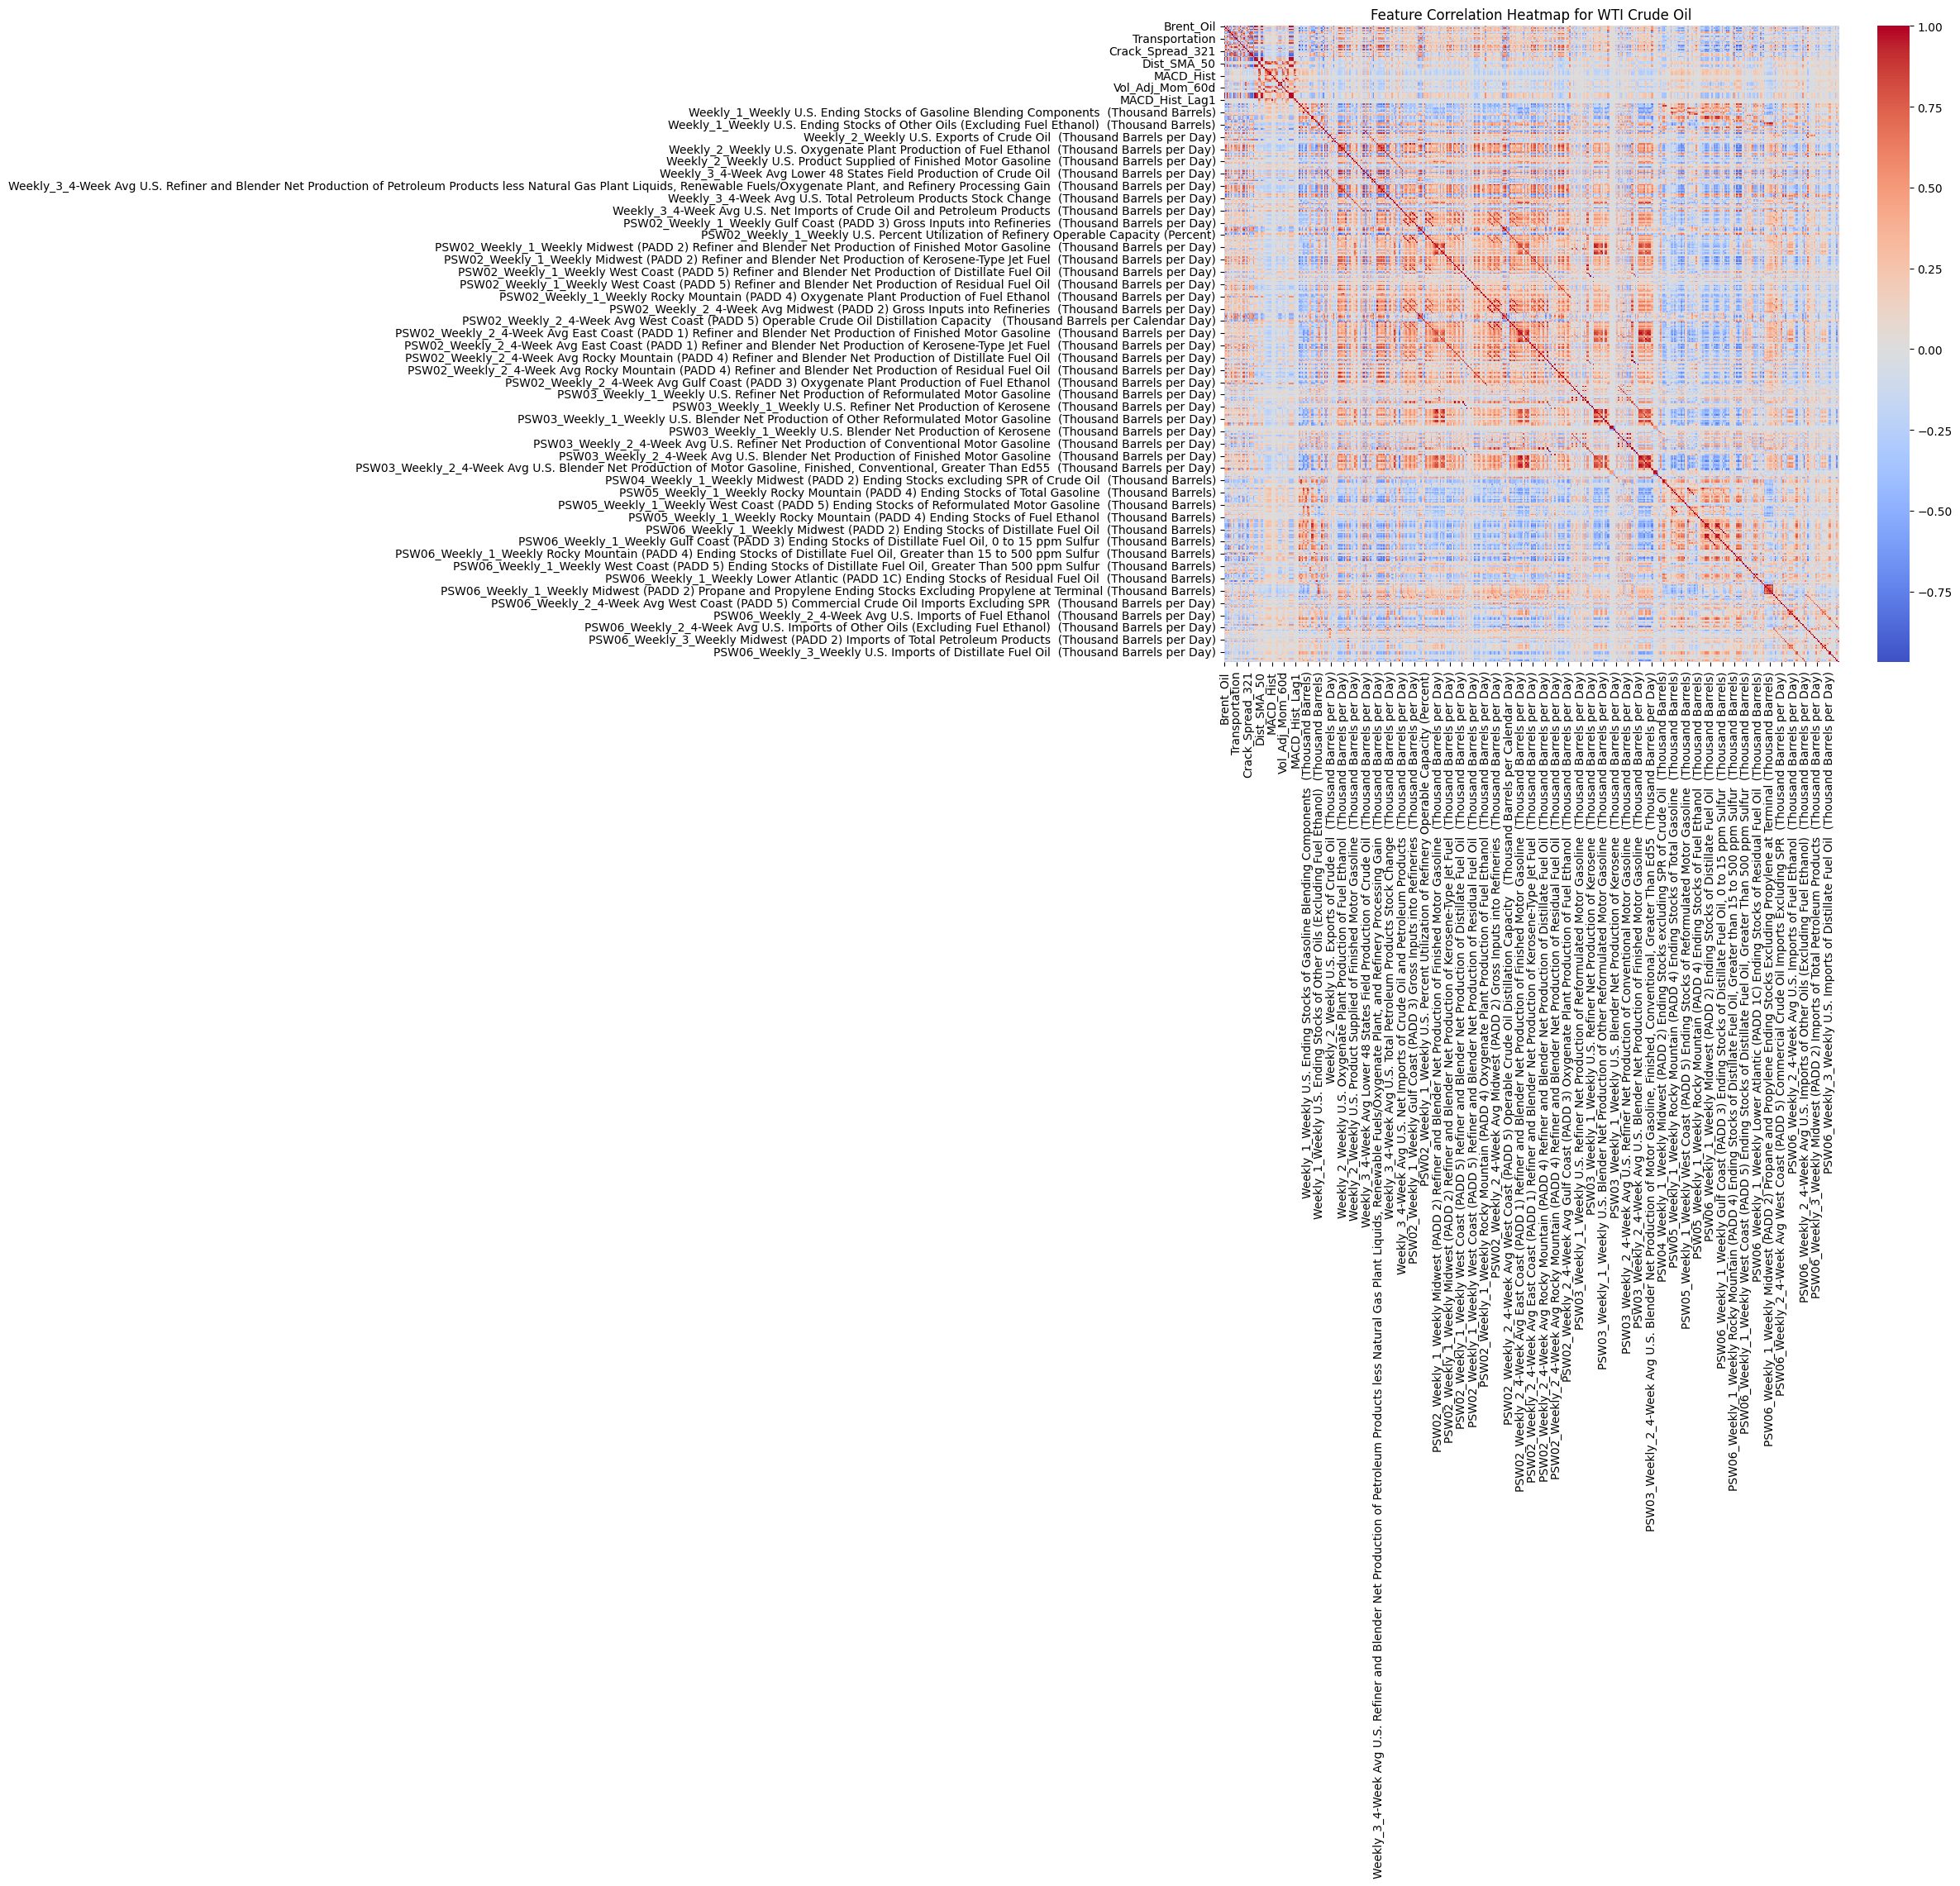

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_all.corr()
oil_corr = corr_matrix['Crude_Oil'].sort_values(ascending=False)
print(oil_corr.head(6)) 
print(oil_corr.tail(5))
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap for WTI Crude Oil")
plt.show()

---

## Pipeline Summary 

**Complete Data Pipeline:**

1. ✓ **Data Collection** - Downloaded 18 financial instruments from Yahoo Finance (2021-01-01 onwards)
2. ✓ **Feature Engineering** - Created 5 ratio features (Crack Spread, Gold/Oil, Copper/Oil, Transport/Oil, Services/Oil)
3. ✓ **Weekly Data Integration** - Merged 7 Excel files (15 sheets) of weekly fundamental data with daily resampling
4. ✓ **Data Quality Validation** - Comprehensive 9-step quality assessment
5. ✓ **Weekly Alignment Verification** - Validated forward-fill logic for weekly-to-daily conversion
6. ✓ **Data Cleaning** - Removed features with >50% missing values, zero variance, and infinite values
7. ✓ **Export** - Saved cleaned dataset to CSV

**Final Dataset:**
- Date Range: 2021-01-01 onwards
- Frequency: Daily (with forward-filled weekly fundamentals)
- Features: Price data + Engineered ratios + Weekly fundamentals
- Quality: Clean, validated, ready for modeling

**Next Steps:**
- Feature selection / dimensionality reduction
- Train/test split
- Model development (LSTM, Random Forest, etc.)
- Backtesting and validation

---

## Step 13: Export Cleaned Dataset

Save the cleaned dataset to CSV file for further analysis and modeling.

In [ ]:
print("=" * 80)
print("EXPORTING CLEANED DATASET")
print("=" * 80)

# Define output file path
output_file = '/Users/arthurf/Desktop/INDENG 242A/cleaned_oil_prediction_data.csv'

# Export to CSV
df_all.to_csv(output_file, index=True, encoding='utf-8')

print(f"\n✓ Dataset exported successfully!")
print(f"  File: {output_file}")
print(f"  Shape: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
print(f"  Size: {df_all.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  Date range: {df_all.index.min().date()} to {df_all.index.max().date()}")

# Show column summary
price_cols = [col for col in df_all.columns if not any(col.startswith(p) for p in ['Weekly', 'PSW'])]
weekly_cols = [col for col in df_all.columns if any(col.startswith(p) for p in ['Weekly', 'PSW'])]

print(f"\n  Columns included:")
print(f"    - Price/Ratio features: {len(price_cols)}")
print(f"    - Weekly fundamental features: {len(weekly_cols)}")

print("\n" + "=" * 80)
print("✓ Export complete!")
print("=" * 80)

EXPORTING CLEANED DATASET

✓ Dataset exported successfully!
  File: /Users/arthurf/Desktop/INDENG 242A/cleaned_oil_prediction_data.csv
  Shape: 1229 rows × 467 columns
  Size: 4.42 MB
  Date range: 2021-01-04 to 2025-11-24

  Columns included:
    - Price/Ratio features: 57
    - Weekly fundamental features: 410

✓ Export complete!

💡 To reload this data: df = pd.read_csv('/Users/arthurf/Desktop/INDENG 242A/cleaned_oil_prediction_data.csv', index_col=0, parse_dates=True)
💡 Backup available as: df_backup (in memory)
